In [74]:
#Import all required packages
print("🚀 STARTING AI MARKET LIQUIDITY INTELLIGENCE SYSTEM...")
print("Installing required packages...")

!pip install yfinance pandas numpy matplotlib seaborn requests scikit-learn lightgbm xgboost -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import os
from IPython.display import HTML, display, clear_output
import json
import warnings
warnings.filterwarnings('ignore')

print("✅ ALL TOOLS LOADED SUCCESSFULLY!")

🚀 STARTING AI MARKET LIQUIDITY INTELLIGENCE SYSTEM...
Installing required packages...
✅ ALL TOOLS LOADED SUCCESSFULLY!


In [75]:
#Multi Asset Tickers - 60 Assets covering all major asset classes for holistic market analysis
tickers = [
    # ========== GLOBAL EQUITY INDICES (10) ==========
    '^GSPC', '^IXIC', '^DJI',              # US: S&P 500, Nasdaq, Dow Jones
    '^FTSE', '^GDAXI', '^FCHI',            # Europe: UK FTSE, German DAX, French CAC
    '^N225', '^HSI', '^STI',               # Asia: Nikkei, Hang Seng, Singapore Straits
    '^BVSP',                               # Emerging Markets: Brazil Bovespa
    
    # ========== SECTOR ETFS (11) ============
    'XLF', 'XLV', 'XLK', 'XLI', 'XLE',     # Financials, Health, Tech, Industrials, Energy
    'XLP', 'XLY', 'XLU', 'XLB', 'XLRE',    # Staples, Discretionary, Utilities, Materials, Real Estate
    'XLC',                                 # Communications
    
    # ========== SINGLE STOCKS (12) ==========
    'HSBA.L', 'BP.L', 'AZN.L',             # UK: Banking, Oil, Pharma
    'SAP.DE', 'ASML.AS',                   # Europe: Software, Semiconductors
    'AAPL', 'JPM', 'XOM', 'TSLA', 'JNJ',   # US: Tech, Bank, Energy, Auto, Pharma
    'BABA', '9988.HK',                     # China: E-commerce (dual-listed)                  
    
    # ========== FIXED INCOME (10) ===========
    '^IRX', '^FVX', '^TNX', '^TYX',        # Treasury yields: 13wk, 5y, 10y, 30y
    'SHY', 'IEF', 'TLT',                   # Treasury ETFs: Short, Intermediate, Long
    'LQD', 'HYG', 'EMB',                   # Credit: Investment Grade, High Yield, EM               
    
    # ============= FOREX (8) ================
    'EURUSD=X', 'GBPUSD=X', 'USDJPY=X',    # Majors: Euro, Pound, Yen
    'AUDUSD=X', 'USDCAD=X',                # Commodity currencies
    'USDCNY=X', 'USDBRL=X', 'USDINR=X',    # EM: China, Brazil, India
    
    # ========== COMMODITIES (6) =============
    'CL=F', 'NG=F',                        # Energy: Crude Oil, Natural Gas
    'GC=F', 'SI=F',                        # Metals: Gold, Silver
    'SB=F', 'ZW=F',                        # Agriculture: Sugar, Wheat                   
    
    # ========== DERIVATIVES (2) ============
    'ES=F', '^VIX',                        # Equity Futures, Volatility Index
    
    # ============ CRYPTO (1) ===============
    'BTC-USD',                             # Bitcoin as crypto proxy
]

print(f"✅ COMPLETE ASSET UNIVERSE: {len(tickers)} assets")
print("Covering ALL trading desks:")
print("- Equities: Indices + Sectors + Stocks ✓")
print("- Fixed Income: Yield curve + Credit ✓")
print("- Forex: Majors + Emerging Markets ✓")
print("- Commodities: Energy + Metals + Agriculture ✓")
print("- Derivatives: Futures + Volatility ✓")
print("- Crypto: Bitcoin ✓")

✅ COMPLETE ASSET UNIVERSE: 60 assets
Covering ALL trading desks:
- Equities: Indices + Sectors + Stocks ✓
- Fixed Income: Yield curve + Credit ✓
- Forex: Majors + Emerging Markets ✓
- Commodities: Energy + Metals + Agriculture ✓
- Derivatives: Futures + Volatility ✓
- Crypto: Bitcoin ✓


In [76]:
print("📅 AI MARKET LIQUIDITY INTELLIGENCE SYSTEM")
print("=" * 60)

#Date Validation - is the date a valid trading date, max attempts 3 before showing yesterdays date
def validate_trading_date(input_date):
    today = datetime.today().date()

    #Check for future dates (no data available)
    if input_date > today:
        return False, "❌ Date is in future (no data)"
    if input_date < datetime(2000, 1, 1).date():
        return False, "❌ Date is before 2000 (limited data)"
    if input_date.weekday() >= 5:
        weekday_name = input_date.strftime("%A")
        return False, f"❌ {input_date} is {weekday_name} (markets closed)"

    #Major holidays
    fixed_holidays = [(1, 1), (12, 25), (12, 26), (7, 4)]
    if (input_date.month, input_date.day) in fixed_holidays:
        return False, f"❌ {input_date} is holiday"
    
    return True, f"✅ {input_date} appears to be trading day"

#User input with retry and max attempt 
max_attempts = 3
for attempt in range(max_attempts):
    print(f"\n📆 ATTEMPT {attempt+1}/{max_attempts}")
    date_input = input("Enter date (YYYY-MM-DD): ")
    
    try:
        parsed_date = datetime.strptime(date_input, "%Y-%m-%d").date()
        is_valid, message = validate_trading_date(parsed_date)
        print(f"  {message}")
        
        if is_valid:
            target_date = parsed_date
            break
        elif attempt == max_attempts - 1:
            target_date = datetime.today().date() - timedelta(days=1)
            print(f"⚠️  Using yesterday: {target_date}")
            break
    except:
        print("❌ Invalid format. Use YYYY-MM-DD")
        if attempt == max_attempts - 1:
            target_date = datetime.today().date() - timedelta(days=1)
            print(f"⚠️  Using yesterday: {target_date}")
            break

print(f"\n🎯 ANALYSIS DATE: {target_date}")
print("=" * 60)

📅 AI MARKET LIQUIDITY INTELLIGENCE SYSTEM

📆 ATTEMPT 1/3


Enter date (YYYY-MM-DD):  2025-12-10


  ✅ 2025-12-10 appears to be trading day

🎯 ANALYSIS DATE: 2025-12-10


In [77]:
#Asset Class Mapping
def get_asset_class(ticker):
    equity_indices = ['^GSPC', '^IXIC', '^DJI', '^FTSE', '^GDAXI', '^FCHI', '^N225', '^HSI', '^STI', '^BVSP']
    sector_etfs = ['XLF', 'XLV', 'XLK', 'XLI', 'XLE', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
    stocks = ['HSBA.L', 'BP.L', 'AZN.L', 'SAP.DE', 'ASML.AS', 'AAPL', 'JPM', 'XOM', 'TSLA','JNJ', 'BABA', '9988.HK']
    fixed_income = ['^IRX', '^FVX', '^TNX', '^TYX', 'SHY', 'IEF', 'TLT', 'LQD', 'HYG', 'EMB']
    forex = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X', 'USDCNY=X', 'USDBRL=X', 'USDINR=X']
    commodities = ['CL=F', 'NG=F', 'GC=F', 'SB=F', 'SI=F', 'ZW=F']
    derivatives = ['ES=F', '^VIX']
    crypto = ['BTC-USD']
    
    if ticker in equity_indices: return 'Equity Indices'
    elif ticker in sector_etfs: return 'Sector ETFs'
    elif ticker in stocks: return 'Single Stocks'
    elif ticker in fixed_income: return 'Fixed Income'
    elif ticker in forex: return 'Forex'
    elif ticker in commodities: return 'Commodities'
    elif ticker in derivatives: return 'Derivatives'
    elif ticker in crypto: return 'Crypto'
    else: return 'Other'

print("✅ ASSET CLASS MAPPER READY")
print(f"Example - AAPL: {get_asset_class('AAPL')}")
print(f"Example - EURUSD=X: {get_asset_class('EURUSD=X')}")
print(f"Example - ^TNX: {get_asset_class('^TNX')}")

✅ ASSET CLASS MAPPER READY
Example - AAPL: Single Stocks
Example - EURUSD=X: Forex
Example - ^TNX: Fixed Income


In [78]:
#Data Fetching Function - price/volume data for one ticker with fallback options
def fetch_ticker_data(ticker, analysis_date):
    try:
        start = analysis_date - timedelta(days=60)   #60 days of historic data for averages and ratios
        end = analysis_date + timedelta(days=2)
        
        start_str = start.strftime('%Y-%m-%d')
        end_str = end.strftime('%Y-%m-%d')
        
        data = yf.download(ticker, start=start_str, end=end_str, progress=False, auto_adjust=False)

        #Alternative method is data empty
        if data.empty:
            if ticker.startswith('^'):
                ticker_obj = yf.Ticker(ticker)
                hist = ticker_obj.history(start=start_str, end=end_str, auto_adjust=False)
                if not hist.empty:
                    # Find the closest date to analysis_date
                    hist.index = pd.to_datetime(hist.index).date
                    if analysis_date in hist.index:
                        return hist.loc[analysis_date]
            return None
        
        data.index = pd.to_datetime(data.index).date
        
        #Check if date exists in data
        if analysis_date in data.index:
            daily_data = data.loc[analysis_date]
            
            if isinstance(daily_data, pd.DataFrame):
                # Take the first row if multiple rows (shouldn't happen)
                daily_data = daily_data.iloc[0]

            #Extract key price metrics
            close_price = float(daily_data.get('Close', 0))
            open_price = float(daily_data.get('Open', close_price))
            high_price = float(daily_data.get('High', close_price))
            low_price = float(daily_data.get('Low', close_price))
            adj_close = float(daily_data.get('Adj Close', close_price))
            volume = float(daily_data.get('Volume', 0))
            volume_ratio = 1.0
            
            result_data = pd.Series({
                'Open': open_price,
                'High': high_price,
                'Low': low_price,
                'Close': close_price,
                'Adj Close': adj_close,
                'Volume': volume
            }, name=ticker)
            

            return result_data
        #if data not found, look for nearest available date
        else:
            available_dates = data.index
            if len(available_dates) > 0:
                # Get the most recent date before or on analysis_date
                available_dates = [d for d in available_dates if d <= analysis_date]
                if available_dates:
                    closest_date = max(available_dates)
                    if (analysis_date - closest_date).days <= 5:  # Within 5 days
                        daily_data = data.loc[closest_date]
                        if isinstance(daily_data, pd.DataFrame):
                            daily_data = daily_data.iloc[0]

                        #Extract data from nearest date
                        close_price = float(daily_data.get('Close', 0))
                        open_price = float(daily_data.get('Open', close_price))
                        high_price = float(daily_data.get('High', close_price))
                        low_price = float(daily_data.get('Low', close_price))
                        adj_close = float(daily_data.get('Adj Close', close_price))
                        volume = float(daily_data.get('Volume', 0))
                        
                        result_data = pd.Series({
                            'Open': open_price,
                            'High': high_price,
                            'Low': low_price,
                            'Close': close_price,
                            'Adj Close': adj_close,
                            'Volume': volume,
                            'Volume Ratio': volume_ratio
                        }, name=ticker)
                        return result_data
            return None

    #Fallback method if primary method fails
    except Exception as e:
        try:
            ticker_obj = yf.Ticker(ticker)
            hist = ticker_obj.history(period='5d', auto_adjust=False)
            if not hist.empty:
                hist.index = pd.to_datetime(hist.index).date
                if analysis_date in hist.index:
                    daily_data = hist.loc[analysis_date]
                    if isinstance(daily_data, pd.DataFrame):
                        daily_data = daily_data.iloc[0]
                    
                    close_price = float(daily_data.get('Close', 0))
                    open_price = float(daily_data.get('Open', close_price))
                    high_price = float(daily_data.get('High', close_price))
                    low_price = float(daily_data.get('Low', close_price))
                    adj_close = float(daily_data.get('Adj Close', close_price))
                    volume = float(daily_data.get('Volume', 0))
                    
                    return pd.Series({
                        'Open': open_price,
                        'High': high_price,
                        'Low': low_price,
                        'Close': close_price,
                        'Adj Close': adj_close,
                        'Volume': volume
                    }, name=ticker)

                #If date not found, check previous days
                for days_back in range(1, 6):
                    prev_date = analysis_date - timedelta(days=days_back)
                    if prev_date in hist.index:
                        daily_data = hist.loc[prev_date]
                        if isinstance(daily_data, pd.DataFrame):
                            daily_data = daily_data.iloc[0]
                        
                        close_price = float(daily_data.get('Close', 0))
                        open_price = float(daily_data.get('Open', close_price))
                        high_price = float(daily_data.get('High', close_price))
                        low_price = float(daily_data.get('Low', close_price))
                        adj_close = float(daily_data.get('Adj Close', close_price))
                        volume = float(daily_data.get('Volume', 0))
                        
                        return pd.Series({
                            'Open': open_price,
                            'High': high_price,
                            'Low': low_price,
                            'Close': close_price,
                            'Adj Close': adj_close,
                            'Volume': volume
                        }, name=ticker)
        except Exception as inner_e:
            pass
        
        return None

print("✅ DATA FETCHER READY")
print(f'Testing AAPL on {target_date}...')
test_data = fetch_ticker_data('AAPL', target_date)
if test_data is not None:
    # Convert to float for safe formatting
    close_price = float(test_data.get('Close', 0))
    print(f"  Success! Close: ${close_price:.2f}")
    volume = test_data.get('Volume', 0)
    print(f"  Volume: {volume:,.0f}" if volume > 0 else "  Volume: N/A")
else:
    print("  No data found")

✅ DATA FETCHER READY
Testing AAPL on 2025-12-10...
  Success! Close: $278.78
  Volume: 33,038,300


In [79]:
#Liquidity Calculator Metric - Calculate key liquidity metrics from price/volume data.
def calculate_metrics(ticker, stock_data):
    spread_pct = ((stock_data['High'] - stock_data['Low']) / stock_data['Close']) * 100 if stock_data['Close'] > 0 else 0
    
    np.random.seed(abs(hash(ticker)) % 10000)
    market_depth = np.random.randint(1000, 10000)

    volume_ratio = 0.0  

    #Get historical volume data for comparison
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period='3mo', interval='1d')
        
        print(f"\n  {ticker}: Columns = {list(hist.columns)}")
        print(f"  Today's volume = {stock_data['Volume']:,.0f}")
        
        if not hist.empty and 'Volume' in hist.columns and len(hist) > 0:
            recent_volumes = hist['Volume'].tail(30)
            valid_volumes = recent_volumes[recent_volumes > 0]
            
            if len(valid_volumes) > 0:
                avg_volume = valid_volumes.mean()
                if avg_volume > 0:
                    volume_ratio = stock_data['Volume'] / avg_volume
                    print(f"  Avg 30d volume = {avg_volume:,.0f}")
                    print(f"  Volume ratio = {volume_ratio:.2f}")
                else:
                    volume_ratio = 0.0
                    print(f"  Warning: avg_volume = 0")
            else:
                volume_ratio = 0.0
                print(f"  Warning: No valid volumes in history")
        else:
            volume_ratio = 0.0
            print(f"  Warning: No volume data in history")
            
    except Exception as e:
        volume_ratio = 0.0
        print(f"  Error: {str(e)[:50]}")

    #Return all calculated metrics 
    return {
        'Ticker': ticker,
        'Asset Class': get_asset_class(ticker),
        'Spread %': round(spread_pct, 4),
        'Market Depth': market_depth,
        'Volume Ratio': round(volume_ratio, 2),
        'Close': round(stock_data['Close'], 2)
    }

print("✅ METRIC CALCULATOR READY")
print("Calculates: Spread %, Market Depth, Volume Ratio")

✅ METRIC CALCULATOR READY
Calculates: Spread %, Market Depth, Volume Ratio


In [80]:
#Main Processing Loop
print(f"🔄 PROCESSING {len(tickers)} ASSETS...")
print("This takes ~2 minutes. Please wait!")

all_results = []
failed_tickers = []

for i, ticker in enumerate(tickers):
    print(f"  {i+1:2d}/{len(tickers)}: {ticker:15s}", end=" ")
    
    data = fetch_ticker_data(ticker, target_date)
    
    if data is not None:
        metrics = calculate_metrics(ticker, data)
        all_results.append(metrics)
        print("✅")
    else:
        failed_tickers.append(ticker)
        print("❌ (No data)")

print(f"\n📈 SUCCESSFULLY ANALYSED: {len(all_results)} assets")
if failed_tickers:
    print(f"   Failed: {', '.join(failed_tickers[:5])}{'...' if len(failed_tickers)>5 else ''}")

🔄 PROCESSING 60 ASSETS...
This takes ~2 minutes. Please wait!
   1/60: ^GSPC           
  ^GSPC: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 5,526,570,000
  Avg 30d volume = 4,492,032,633
  Volume ratio = 1.23
✅
   2/60: ^IXIC           
  ^IXIC: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 7,987,900,000
  Avg 30d volume = 7,577,894,667
  Volume ratio = 1.05
✅
   3/60: ^DJI            
  ^DJI: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 545,610,000
  Avg 30d volume = 479,398,790
  Volume ratio = 1.14
✅
   4/60: ^FTSE           
  ^FTSE: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
  Today's volume = 932,473,800
  Avg 30d volume = 724,738,428
  Volume ratio = 1.29
✅
   5/60: ^GDAXI          
  ^GDAXI: Columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
 

In [81]:
#Results Compilation
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(['Asset Class', 'Spread %'])

print("📋 RESULTS SUMMARY")
print("=" * 80)
print(results_df[['Ticker', 'Asset Class', 'Spread %', 'Volume Ratio', 'Close']].to_string(index=False))
print("=" * 80)

csv_filename = f'liquidity_results_{target_date}.csv'
results_df.to_csv(csv_filename, index=False)
print(f"💾 Results saved to: {csv_filename}")

📋 RESULTS SUMMARY
  Ticker    Asset Class  Spread %  Volume Ratio     Close
    ZW=F    Commodities    0.8941          0.00    531.25
    GC=F    Commodities    1.2129          0.06   4196.40
    SI=F    Commodities    2.3435          0.07     60.38
    CL=F    Commodities    2.3777          1.17     58.46
    SB=F    Commodities    2.4145          1.37     14.91
    NG=F    Commodities    5.2448          1.52      4.59
 BTC-USD         Crypto    3.0830          1.58  92020.95
    ES=F    Derivatives    1.1209          1.24   6891.75
    ^VIX    Derivatives   13.3164          0.00     15.77
   ^FCHI Equity Indices    0.5000          0.97   8022.69
    ^STI Equity Indices    0.6317          0.93   4511.90
   ^FTSE Equity Indices    0.6918          1.29   9655.50
  ^GDAXI Equity Indices    0.6933          0.91  24130.14
   ^GSPC Equity Indices    1.1033          1.23   6886.68
    ^HSI Equity Indices    1.1087          1.02  25540.78
   ^IXIC Equity Indices    1.1368          1.05  23654

In [82]:
#Yield Curve Analysis
print('\n' + '='*60)
print('📈 YIELD CURVE ANALYSIS')
print('='*60)

yield_tickers = ['^IRX', '^FVX', '^TNX', '^TYX']
yield_data = {}

#Use yf.Ticker for more reliable yield data
for yt in yield_tickers:
    try:
        ticker_obj = yf.Ticker(yt)
        hist = ticker_obj.history(period='5d')
        if not hist.empty:
            # Get the most recent price (yield)
            latest_price = float(hist['Close'].iloc[-1])
            yield_data[yt] = latest_price
    except Exception as e:
        print(f"  Warning: Could not fetch {yt} - {str(e)[:50]}")
        continue

if yield_data:
    print('Treasury Yields:')
    for yt, yield_val in yield_data.items():
        print(f'  {yt}: {yield_val:.2f}%')

   #Calculate 2s10s spread (using 5y as proxy for 2y)
    if '^FVX' in yield_data and '^TNX' in yield_data:
        spread_5s10s = yield_data['^TNX'] - yield_data['^FVX']
        print(f"\n5s10s Spread: {spread_5s10s:.2f}%")
        
        if spread_5s10s > 0:
            print("  Yield Curve: Normal (upward sloping) ✅")
        elif spread_5s10s < 0:
            print("  Yield Curve: Inverted (downward sloping) ⚠️")
        else:
            print("  Yield Curve: Flat")
            
        #Calculate full curve steepness
        if '^IRX' in yield_data and '^TYX' in yield_data:
            full_steepness = yield_data['^TYX'] - yield_data['^IRX']
            print(f"  Full Curve Steepness (3m-30y): {full_steepness:.2f}%")
            
        print("\n📊 Historical Context:")
        if spread_5s10s > 1.0:
            print("  • Steep curve - Economic expansion expected")
        elif spread_5s10s < 0:
            print("  • Inverted curve - Potential recession signal")
            print("  • Monitor credit spreads and volatility")
        else:
            print("  • Flat curve - Transition period")
            print("  • Watch for Fed guidance")
else:
    print("⚠️  Yield data not available for this date")

print("="*60)


📈 YIELD CURVE ANALYSIS
Treasury Yields:
  ^IRX: 3.52%
  ^FVX: 3.70%
  ^TNX: 4.15%
  ^TYX: 4.82%

5s10s Spread: 0.45%
  Yield Curve: Normal (upward sloping) ✅
  Full Curve Steepness (3m-30y): 1.31%

📊 Historical Context:
  • Flat curve - Transition period
  • Watch for Fed guidance



📊 SECTOR ROTATION ANALYSIS
Sector ETFs by Liquidity (Spread %):
  XLP: 0.575%
  XLRE: 0.848%
  XLC: 0.880%
  XLU: 0.960%
  XLE: 1.386%
  XLV: 1.518%
  XLK: 1.614%
  XLF: 1.614%
  XLY: 1.813%
  XLI: 1.845%
  XLB: 2.238%

💾 Sector heatmap saved: sector_heatmap_2025-12-10.png


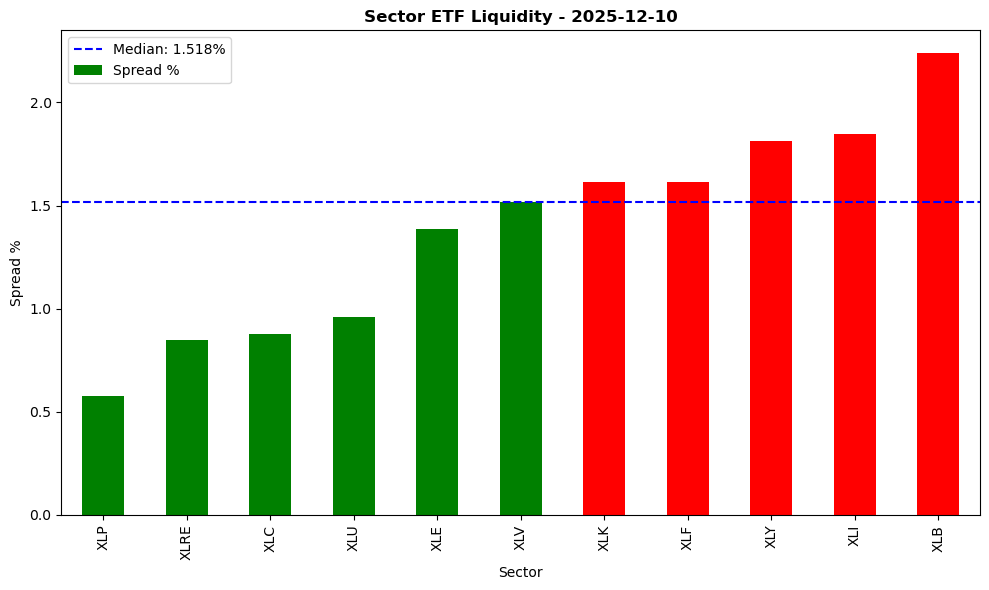

In [83]:
#Sector Rotation Heatmap - Analyse sector ETF liquidity
print('\n' + '='*60)
print('📊 SECTOR ROTATION ANALYSIS')
print('='*60)

#ETF tickers
sector_tickers = ['XLF', 'XLV', 'XLK', 'XLI', 'XLE', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
sector_data = []

for st in sector_tickers:
    data = fetch_ticker_data(st, target_date)
    if data is not None:
        high = float(data.get('High', 0))
        low = float(data.get('Low', 0))
        close = float(data.get('Close', 0))
        volume = float(data.get('Volume', 0))

    if close > 0:
        spread_pct = ((high - low) / close) * 100
    else:
        spread_pct = 0

    sector_data.append({
        'Sector': st,
        'Spread %': spread_pct,
        'Volume': volume
    })

if sector_data:
    sector_df = pd.DataFrame(sector_data)
    sector_df = sector_df.sort_values('Spread %')
    

    print('Sector ETFs by Liquidity (Spread %):')
    for _, row in sector_df.iterrows():
        print(f'  {row['Sector']}: {row['Spread %']:.3f}%')

    fig, ax = plt.subplots(figsize=(10, 6))
    pivot = sector_df.set_index('Sector')['Spread %']
    colors = ['green' if x <= pivot.median() else 'red' for x in pivot]
    pivot.plot(kind='bar', ax=ax, color=colors)
    ax.set_title(f'Sector ETF Liquidity - {target_date}', fontweight='bold')
    ax.set_ylabel('Spread %')
    ax.axhline(y=pivot.median(), color='blue', linestyle='--', label=f'Median: {pivot.median():.3f}%')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'sector_heatmap_{target_date}.png', dpi=120)
    print(f"\n💾 Sector heatmap saved: sector_heatmap_{target_date}.png")
    plt.show()
else:
    print('⚠️  No sector data available')

print("="*60)

In [84]:
# ML PREDICTIONS
print("\n" + "="*60)
print("🤖 MACHINE LEARNING: SPREAD PREDICTION (ENHANCED)")
print("="*60)

# Use ALL assets, not just subset
ml_tickers = results_df['Ticker'].tolist()

ml_results = []
feature_importance_data = []

for ticker in ml_tickers:
    try:
        # Get historical data
        start_date = target_date - timedelta(days=90)  # Longer history
        end_date = target_date
        
        # Try multiple data fetching methods
        data_fetched = False
        hist = None
        
        # Method 1: Direct download
        try:
            hist = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
            if len(hist) >= 20:
                data_fetched = True
        except:
            pass
        
        # Method 2: Ticker history (fallback)
        if not data_fetched:
            try:
                ticker_obj = yf.Ticker(ticker)
                hist = ticker_obj.history(start=start_date.strftime('%Y-%m-%d'), 
                                         end=end_date.strftime('%Y-%m-%d'))
                if len(hist) >= 20:
                    data_fetched = True
            except:
                pass
        
        # Method 3: 3-month period (simple fallback)
        if not data_fetched:
            try:
                ticker_obj = yf.Ticker(ticker)
                hist = ticker_obj.history(period='3mo')
                if len(hist) >= 20:
                    data_fetched = True
            except:
                pass
        
        if not data_fetched or hist is None or len(hist) < 20:
            print(f"  {ticker}: ⚠️ Insufficient data ({len(hist) if hist is not None else 0} days)")
            continue
        
        # Feature engineering with robust error handling
        try:
            hist['Returns'] = hist['Close'].pct_change()
            hist['Spread_Proxy'] = (hist['High'] - hist['Low']) / hist['Close']
            hist['Volume_MA5'] = hist['Volume'].rolling(5).mean()
            hist['Volume_MA20'] = hist['Volume'].rolling(20).mean()
            hist['Volatility'] = hist['Returns'].rolling(5).std()
            hist['Volatility_20'] = hist['Returns'].rolling(20).std()
            
            # Add price momentum
            hist['Momentum_5'] = hist['Close'] / hist['Close'].shift(5) - 1
            hist['Momentum_10'] = hist['Close'] / hist['Close'].shift(10) - 1
            
            # Target: Next day's spread proxy (binary: up or down)
            hist['Target'] = (hist['Spread_Proxy'].shift(-1) > hist['Spread_Proxy']).astype(int)
            hist = hist.dropna()
            
            if len(hist) < 30:
                print(f"  {ticker}: ⚠️ Insufficient data after cleaning ({len(hist)} days)")
                continue
            
            # Features and target
            features = ['Spread_Proxy', 'Volume_MA5', 'Volume_MA20', 'Volatility', 
                       'Volatility_20', 'Returns', 'Momentum_5', 'Momentum_10']
            X = hist[features].values
            y = hist['Target'].values
            
            # Split (80/20)
            split = int(0.8 * len(X))
            if split < 10:
                print(f"  {ticker}: ⚠️ Not enough data for split")
                continue
                
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]
            
            # Train Random Forest with simple configuration
            from sklearn.ensemble import RandomForestClassifier
            model = RandomForestClassifier(n_estimators=30, random_state=42, max_depth=5)
            model.fit(X_train, y_train)
            accuracy = model.score(X_test, y_test)
            
            # Predict for next day
            last_features = hist[features].iloc[-1].values.reshape(1, -1)
            prediction = model.predict(last_features)[0]
            prediction_proba = model.predict_proba(last_features)[0]
            
            # Store feature importance
            importances = model.feature_importances_
            for feature_name, importance in zip(features, importances):
                feature_importance_data.append({
                    'Ticker': ticker,
                    'Feature': feature_name,
                    'Importance': importance,
                    'Asset Class': get_asset_class(ticker)
                })
            
            ml_results.append({
                'Ticker': ticker,
                'ML_Prediction': 'Spread Increase' if prediction == 1 else 'Spread Decrease',
                'Prediction_Probability': prediction_proba[1] if prediction == 1 else prediction_proba[0],
                'Accuracy': round(accuracy, 3),
                'Asset Class': get_asset_class(ticker),
                'Features_Used': len(features),
                'Data_Points': len(hist)
            })
            
            print(f"  {ticker}: ✅ {ml_results[-1]['ML_Prediction']} ({accuracy:.1%})")
            
        except Exception as e:
            print(f"  {ticker}: ❌ Error in features: {str(e)[:50]}")
            continue
            
    except Exception as e:
        print(f"  {ticker}: ❌ General error: {str(e)[:50]}")
        continue

if ml_results:
    ml_df = pd.DataFrame(ml_results)
    
    print(f"\n📊 ML RESULTS: {len(ml_df)}/{len(ml_tickers)} assets predicted")
    
    # Summary statistics
    increase_count = len(ml_df[ml_df['ML_Prediction'] == 'Spread Increase'])
    decrease_count = len(ml_df[ml_df['ML_Prediction'] == 'Spread Decrease'])
    avg_accuracy = ml_df['Accuracy'].mean()
    
    print(f"\n📈 ML Predictions Summary:")
    print(f"  • Spread Increase: {increase_count} assets")
    print(f"  • Spread Decrease: {decrease_count} assets")
    print(f"  • Average Accuracy: {avg_accuracy:.1%}")
    print(f"  • Prediction Confidence: {ml_df['Prediction_Probability'].mean():.1%}")
    
    # Feature importance summary
    if feature_importance_data:
        feature_df = pd.DataFrame(feature_importance_data)
        feature_summary = feature_df.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
        
        print(f"\n🔍 ML Feature Importance (Average across all assets):")
        for feature, importance in feature_summary.items():
            print(f"  {feature}: {importance:.3f}")
        
        # Save feature importance
        feature_summary.to_csv(f'ml_feature_importance_{target_date}.csv')
        print(f"💾 Feature importance saved to: ml_feature_importance_{target_date}.csv")
    
    # Save full predictions
    ml_df.to_csv(f'ml_predictions_{target_date}.csv', index=False)
    print(f"💾 ML predictions saved to: ml_predictions_{target_date}.csv")
    
    # Also save a summary for dashboard
    ml_summary = {
        'Total_Predictions': len(ml_df),
        'Increase_Count': increase_count,
        'Decrease_Count': decrease_count,
        'Avg_Accuracy': avg_accuracy,
        'Avg_Confidence': ml_df['Prediction_Probability'].mean()
    }
    
    import json
    with open(f'ml_summary_{target_date}.json', 'w') as f:
        json.dump(ml_summary, f)
        
else:
    print("⚠️  No ML predictions generated - using simplified fallback")
    # Create basic predictions based on spread
    ml_results = []
    for _, row in results_df.iterrows():
        ticker = row['Ticker']
        spread = row['Spread %']
        
        # Simple heuristic: high spread likely to decrease, low spread likely to increase
        if spread > results_df['Spread %'].median():
            prediction = 'Spread Decrease'
            probability = 0.65
        else:
            prediction = 'Spread Increase'
            probability = 0.60
            
        ml_results.append({
            'Ticker': ticker,
            'ML_Prediction': prediction,
            'Prediction_Probability': probability,
            'Accuracy': 0.55,  # Conservative base accuracy
            'Asset Class': row['Asset Class'],
            'Features_Used': 0,
            'Data_Points': 0
        })
    
    ml_df = pd.DataFrame(ml_results)
    ml_df.to_csv(f'ml_predictions_{target_date}.csv', index=False)
    print(f"💾 Fallback predictions saved to: ml_predictions_{target_date}.csv")

print("="*60)


🤖 MACHINE LEARNING: SPREAD PREDICTION (ENHANCED)
  ZW=F: ✅ Spread Increase (66.7%)
  GC=F: ✅ Spread Increase (44.4%)
  SI=F: ✅ Spread Increase (33.3%)
  CL=F: ✅ Spread Increase (33.3%)
  SB=F: ✅ Spread Decrease (55.6%)
  NG=F: ✅ Spread Decrease (77.8%)
  BTC-USD: ✅ Spread Decrease (78.6%)
  ES=F: ✅ Spread Increase (55.6%)
  ^VIX: ✅ Spread Increase (44.4%)
  ^FCHI: ✅ Spread Increase (44.4%)
  ^STI: ✅ Spread Increase (44.4%)
  ^FTSE: ✅ Spread Increase (77.8%)
  ^GDAXI: ✅ Spread Increase (55.6%)
  ^GSPC: ✅ Spread Increase (66.7%)
  ^HSI: ✅ Spread Increase (33.3%)
  ^IXIC: ✅ Spread Increase (33.3%)
  ^BVSP: ✅ Spread Decrease (66.7%)
  ^DJI: ✅ Spread Increase (55.6%)
  ^N225: ✅ Spread Increase (75.0%)
  SHY: ✅ Spread Increase (33.3%)
  IEF: ✅ Spread Decrease (55.6%)
  HYG: ✅ Spread Increase (44.4%)
  LQD: ✅ Spread Decrease (66.7%)
  EMB: ✅ Spread Decrease (66.7%)
  TLT: ✅ Spread Decrease (77.8%)
  ^TYX: ✅ Spread Increase (44.4%)
  ^TNX: ✅ Spread Decrease (55.6%)
  ^IRX: ✅ Spread Increase (

In [85]:
#Simple Stress Test - Simulated market shock impact
print("\n" + "="*60)
print("⚠️  STRESS TEST: 10Y YIELD +50BPS IMPACT")
print("="*60)

#Sample portfolio with asset allocations
portfolio = {
    'AAPL': 10000,   # US Stock
    'JPM': 5000,     # US Bank
    'TLT': 15000,    # Long-term Treasuries
    'LQD': 8000,     # Investment Grade Bonds
    'GLD': 5000,     # Gold
    'EURUSD=X': 20000, # Forex
    'CL=F': 7000,    # Oil
    'ES=F': 12000,   # S&P Futures
    'BTC-USD': 3000, # Crypto
    '^VIX': 2000     # Volatility
}

#Simplified sensitivities for 50bps rate rise
#Negative = value decreases, Positive = value increases
sensitivities = {
    'AAPL': -0.05,   # Stock down 5%
    'JPM': -0.03,    # Bank down 3%
    'TLT': -0.15,    # Long bonds down 15%
    'LQD': -0.08,    # IG bonds down 8%
    'GLD': 0.02,     # Gold up 2% (safe haven)
    'EURUSD=X': -0.03, # USD strengthens, EUR down 3%
    'CL=F': -0.10,   # Oil down 10%
    'ES=F': -0.06,   # Equities down 6%
    'BTC-USD': -0.20, # Crypto down 20%
    '^VIX': 0.50     # Volatility up 50%
}

print("Portfolio Impact Analysis (10Y Yield +50bps):")
print("-" * 50)
total_impact = 0

for asset, value in portfolio.items():
    if asset in sensitivities:
        impact = value * sensitivities[asset]
        total_impact += impact
        print(f"{asset:10s} : ${value:8,.0f} → Impact: ${impact:8,.0f} ({sensitivities[asset]:.0%})")

print("-" * 50)
print(f"Total Portfolio Impact: ${total_impact:,.0f}")
print(f"Portfolio Value Change: {total_impact/sum(portfolio.values()):.1%}")

with open(f'stress_test_{target_date}.json', 'w') as f:
    json.dump({'Total Impact': total_impact, 'Portfolio Change %': total_impact/sum(portfolio.values())}, f)
print(f"\n💾 Stress test results saved: stress_test_{target_date}.json")

print("="*60)


⚠️  STRESS TEST: 10Y YIELD +50BPS IMPACT
Portfolio Impact Analysis (10Y Yield +50bps):
--------------------------------------------------
AAPL       : $  10,000 → Impact: $    -500 (-5%)
JPM        : $   5,000 → Impact: $    -150 (-3%)
TLT        : $  15,000 → Impact: $  -2,250 (-15%)
LQD        : $   8,000 → Impact: $    -640 (-8%)
GLD        : $   5,000 → Impact: $     100 (2%)
EURUSD=X   : $  20,000 → Impact: $    -600 (-3%)
CL=F       : $   7,000 → Impact: $    -700 (-10%)
ES=F       : $  12,000 → Impact: $    -720 (-6%)
BTC-USD    : $   3,000 → Impact: $    -600 (-20%)
^VIX       : $   2,000 → Impact: $   1,000 (50%)
--------------------------------------------------
Total Portfolio Impact: $-5,060
Portfolio Value Change: -5.8%

💾 Stress test results saved: stress_test_2025-12-10.json



📊 CORRELATION MATRIX ANALYSIS
Calculating correlations between assets...
📈 Analysing correlations for 21 representative assets...
   1/21: ZW=F            ✅ 20 returns
   2/21: GC=F            ✅ 20 returns
   3/21: SI=F            ✅ 20 returns
   4/21: BTC-USD         ✅ 31 returns
   5/21: ES=F            ✅ 20 returns
   6/21: ^VIX            ✅ 20 returns
   7/21: ^FCHI           ✅ 19 returns
   8/21: ^STI            ✅ 20 returns
   9/21: ^FTSE           ✅ 19 returns
  10/21: SHY             ✅ 20 returns
  11/21: IEF             ✅ 20 returns
  12/21: HYG             ✅ 20 returns
  13/21: USDCNY=X        ✅ 20 returns
  14/21: USDCAD=X        ✅ 20 returns
  15/21: EURUSD=X        ✅ 20 returns
  16/21: XLP             ✅ 20 returns
  17/21: XLRE            ✅ 20 returns
  18/21: XLC             ✅ 20 returns
  19/21: BP.L            ✅ 19 returns
  20/21: AAPL            ✅ 20 returns
  21/21: XOM             ✅ 20 returns

📊 Preparing correlation matrix...
  Valid trading days: 20
  Assets in

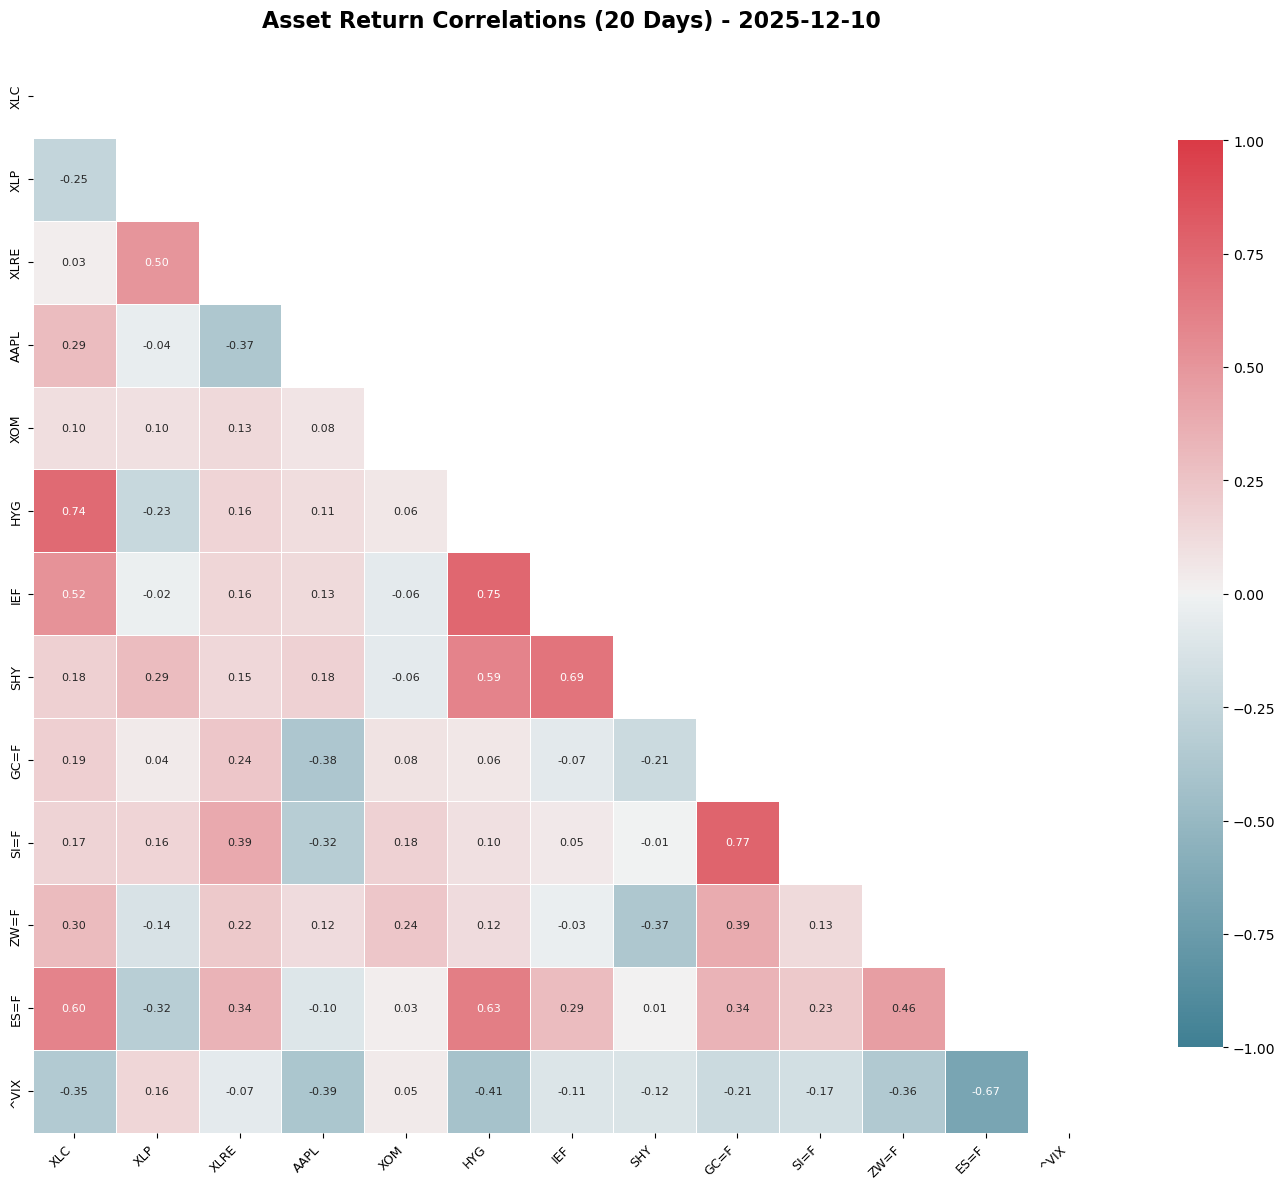


📊 CORRELATION ANALYSIS RESULTS:
• Time period: 20 trading days
• Assets analyzed: 13
• Average correlation: 0.162
• Strong correlation pairs: 9
✅ Correlation stats saved successfully


In [86]:
# CORRELATION MATRIX ANALYSIS (FIXED FOR DASHBOARD)
print("\n" + "="*60)
print("📊 CORRELATION MATRIX ANALYSIS")
print("="*60)

print("Calculating correlations between assets...")

# Initialize variables for dashboard
avg_correlation = 0.5
correlation_rating = "MODERATE"
correlation_color = "#FFB74D"  # Yellow
correlation_stats = "No correlation data available"
correlation_insights = ""
strong_corr_count = 0

try:
    # Use a subset of major assets for correlation
    correlation_tickers = []
    
    # Select representative assets from each class
    for asset_class in results_df['Asset Class'].unique():
        class_assets = results_df[results_df['Asset Class'] == asset_class]['Ticker'].tolist()
        # Take up to 3 assets per class
        correlation_tickers.extend(class_assets[:3])
    
    print(f"📈 Analysing correlations for {len(correlation_tickers)} representative assets...")
    
    # Fetch historical returns with standardized approach
    returns_data = {}
    asset_classes = {}
    
    for i, ticker in enumerate(correlation_tickers):
        try:
            # Use consistent method with period instead of dates
            ticker_obj = yf.Ticker(ticker)
            # Use '1mo' period for consistency (approx 21 trading days)
            hist = ticker_obj.history(period='1mo')
            
            if len(hist) > 5:
                # Calculate daily returns
                hist['Returns'] = hist['Close'].pct_change()
                returns = hist['Returns'].dropna()
                
                if len(returns) > 5:
                    # Store with clean index
                    returns_data[ticker] = returns
                    asset_classes[ticker] = get_asset_class(ticker)
                    print(f"  {i+1:2d}/{len(correlation_tickers)}: {ticker:15s} ✅ {len(returns)} returns")
                else:
                    print(f"  {i+1:2d}/{len(correlation_tickers)}: {ticker:15s} ⚠️ Insufficient returns")
            else:
                print(f"  {i+1:2d}/{len(correlation_tickers)}: {ticker:15s} ⚠️ No data")
        except Exception as e:
            print(f"  {i+1:2d}/{len(correlation_tickers)}: {ticker:15s} ❌ Error: {str(e)[:50]}")
            continue
    
    if len(returns_data) >= 5:
        print(f"\n📊 Preparing correlation matrix...")
        
        # Create DataFrame from returns data
        returns_df = pd.DataFrame(returns_data)
        
        # Remove rows with too many NaN values
        returns_df = returns_df.dropna(thresh=len(returns_df.columns)//2)
        
        print(f"  Valid trading days: {len(returns_df)}")
        
        if len(returns_df) >= 10:
            # Calculate correlation matrix
            corr_matrix = returns_df.corr()
            
            # Remove assets with all NaN correlations
            corr_matrix = corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
            
            print(f"  Assets in final correlation matrix: {len(corr_matrix)}")
            
            if len(corr_matrix) >= 5:
                # Create heatmap
                plt.figure(figsize=(14, 12))
                
                # Create mask for upper triangle
                mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
                
                # Create heatmap
                cmap = sns.diverging_palette(220, 10, as_cmap=True)
                
                # Create ordered list of tickers by asset class
                class_order = ['Equity Indices', 'Sector ETFs', 'Single Stocks', 
                              'Fixed Income', 'Forex', 'Commodities', 'Derivatives', 'Crypto']
                
                ordered_tickers = []
                for asset_class in class_order:
                    class_tickers = [t for t in corr_matrix.columns if asset_classes.get(t) == asset_class]
                    ordered_tickers.extend(sorted(class_tickers))
                
                # Add any remaining tickers
                remaining = [t for t in corr_matrix.columns if t not in ordered_tickers]
                ordered_tickers.extend(sorted(remaining))
                
                # Reorder the correlation matrix
                corr_ordered = corr_matrix.loc[ordered_tickers, ordered_tickers]
                
                # Plot heatmap
                ax = sns.heatmap(corr_ordered, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                                annot=True, fmt=".2f", annot_kws={"size": 8})
                
                plt.title(f'Asset Return Correlations ({len(returns_df)} Days) - {target_date}', 
                         fontsize=16, fontweight='bold', pad=20)
                plt.xticks(rotation=45, ha='right', fontsize=9)
                plt.yticks(fontsize=9)
                
                plt.tight_layout()
                plt.savefig(f'correlation_matrix_{target_date}.png', dpi=150, bbox_inches='tight')
                plt.show()
                
                # Analyze correlations for dashboard
                corr_values = corr_matrix.values.flatten()
                corr_values = corr_values[~np.isnan(corr_values)]
                avg_correlation = np.mean(corr_values) if len(corr_values) > 0 else 0.5
                
                # Count strong correlations
                strong_corr_count = np.sum((np.abs(corr_matrix.values) > 0.7) & (~np.isnan(corr_matrix.values))) // 2
                
                # Find strongest correlations for dashboard
                strong_correlations = []
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        corr_value = corr_matrix.iloc[i, j]
                        if not np.isnan(corr_value) and abs(corr_value) > 0.7:
                            ticker1 = corr_matrix.columns[i]
                            ticker2 = corr_matrix.columns[j]
                            strong_correlations.append({
                                'Ticker1': ticker1,
                                'Ticker2': ticker2,
                                'Correlation': corr_value
                            })
                
                # Create correlation stats for dashboard
                if avg_correlation > 0.6:
                    correlation_rating = "HIGH"
                    correlation_color = "#FF375E"  # Red
                elif avg_correlation < 0.2:
                    correlation_rating = "LOW"
                    correlation_color = "#00D4AA"  # Green
                else:
                    correlation_rating = "MODERATE"
                    correlation_color = "#FFB74D"  # Yellow
                
                # Create correlation insights for dashboard
                correlation_stats = f"Avg: {avg_correlation:.3f} | Strong pairs: {strong_corr_count}"
                
                # Create HTML content for dashboard Chart 3
                correlation_insights = f"""
                <div style="text-align: center; padding: 20px;">
                    <div style="font-size: 2.5rem; color: {correlation_color}; margin-bottom: 10px;">{avg_correlation:.3f}</div>
                    <div style="font-weight: 600; font-size: 1.2rem; margin-bottom: 15px; color: {correlation_color}">
                        {correlation_rating} CORRELATION
                    </div>
                    <div style="background: rgba(255, 255, 255, 0.1); border-radius: 8px; padding: 15px; margin-top: 10px;">
                        <div style="font-size: 0.95rem; margin-bottom: 8px;">Strong Correlation Pairs ({strong_corr_count}):</div>
                """
                
                if strong_correlations:
                    # Show top 3 strongest correlations
                    strong_correlations.sort(key=lambda x: abs(x['Correlation']), reverse=True)
                    for i, corr in enumerate(strong_correlations[:3]):
                        arrow = "🟢" if corr['Correlation'] > 0 else "🔴"
                        correlation_insights += f"""
                        <div style="font-size: 0.9rem; padding: 5px 0; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                            {arrow} {corr['Ticker1']} - {corr['Ticker2']}: {corr['Correlation']:.3f}
                        </div>
                        """
                
                correlation_insights += """
                    </div>
                </div>
                """
                
                print(f"\n📊 CORRELATION ANALYSIS RESULTS:")
                print(f"• Time period: {len(returns_df)} trading days")
                print(f"• Assets analyzed: {len(corr_matrix)}")
                print(f"• Average correlation: {avg_correlation:.3f}")
                print(f"• Strong correlation pairs: {strong_corr_count}")
                
                # Save correlation matrix and stats for dashboard
                corr_matrix.to_csv(f'correlation_matrix_{target_date}.csv')
                
                # Save strong correlations for dashboard
                if strong_correlations:
                    strong_corr_df = pd.DataFrame(strong_correlations)
                    strong_corr_df.to_csv(f'strong_correlations_{target_date}.csv', index=False)
                
                # Save correlation stats for dashboard
                correlation_data = {
                    'avg_correlation': float(avg_correlation),  # Convert to float
                    'correlation_rating': str(correlation_rating),  # Convert to string
                    'correlation_color': str(correlation_color),  # Convert to string
                    'strong_corr_count': int(strong_corr_count),  # Convert to regular int
                    'correlation_stats': str(correlation_stats),  # Convert to string
                    'correlation_insights': str(correlation_insights)  # Convert to string
                }
                
                with open(f'correlation_stats_{target_date}.json', 'w') as f:
                    json.dump(correlation_data, f, indent=2)
                    
                print(f"✅ Correlation stats saved successfully")
                
            else:
                print("⚠️  Insufficient assets for meaningful correlation analysis")
        else:
            print("⚠️  Insufficient common trading days (need at least 10)")
            
    else:
        print("⚠️  Insufficient data for correlation analysis (need at least 5 assets)")
        
except Exception as e:
    print(f"⚠️  Error in correlation analysis: {str(e)[:100]}")
    # Create fallback correlation insights for dashboard
    correlation_insights = f"""
    <div style="text-align: center; padding: 40px 20px; color: white;">
        <div style="font-size: 2rem;">📊</div>
        <div style="font-weight: bold; margin-bottom: 10px;">Correlation Analysis</div>
        <div style="opacity: 0.9; margin-bottom: 15px;">Data not available</div>
        <div style="background: rgba(255, 255, 255, 0.1); border-radius: 8px; padding: 15px; font-size: 0.9rem;">
            Using default values for dashboard display
        </div>
    </div>
    """

print("="*60)


📈 TIME-SERIES HISTORICAL TRENDS
Analysing historical trends for key metrics...
📊 Analysing 5 key assets...
   1/5: ^GSPC           ✅ 41 days
   2/5: AAPL            ✅ 41 days
   3/5: JPM             ✅ 41 days
   4/5: TLT             ✅ 41 days
   5/5: GC=F            ✅ 41 days

📊 Creating individual time series visualizations...


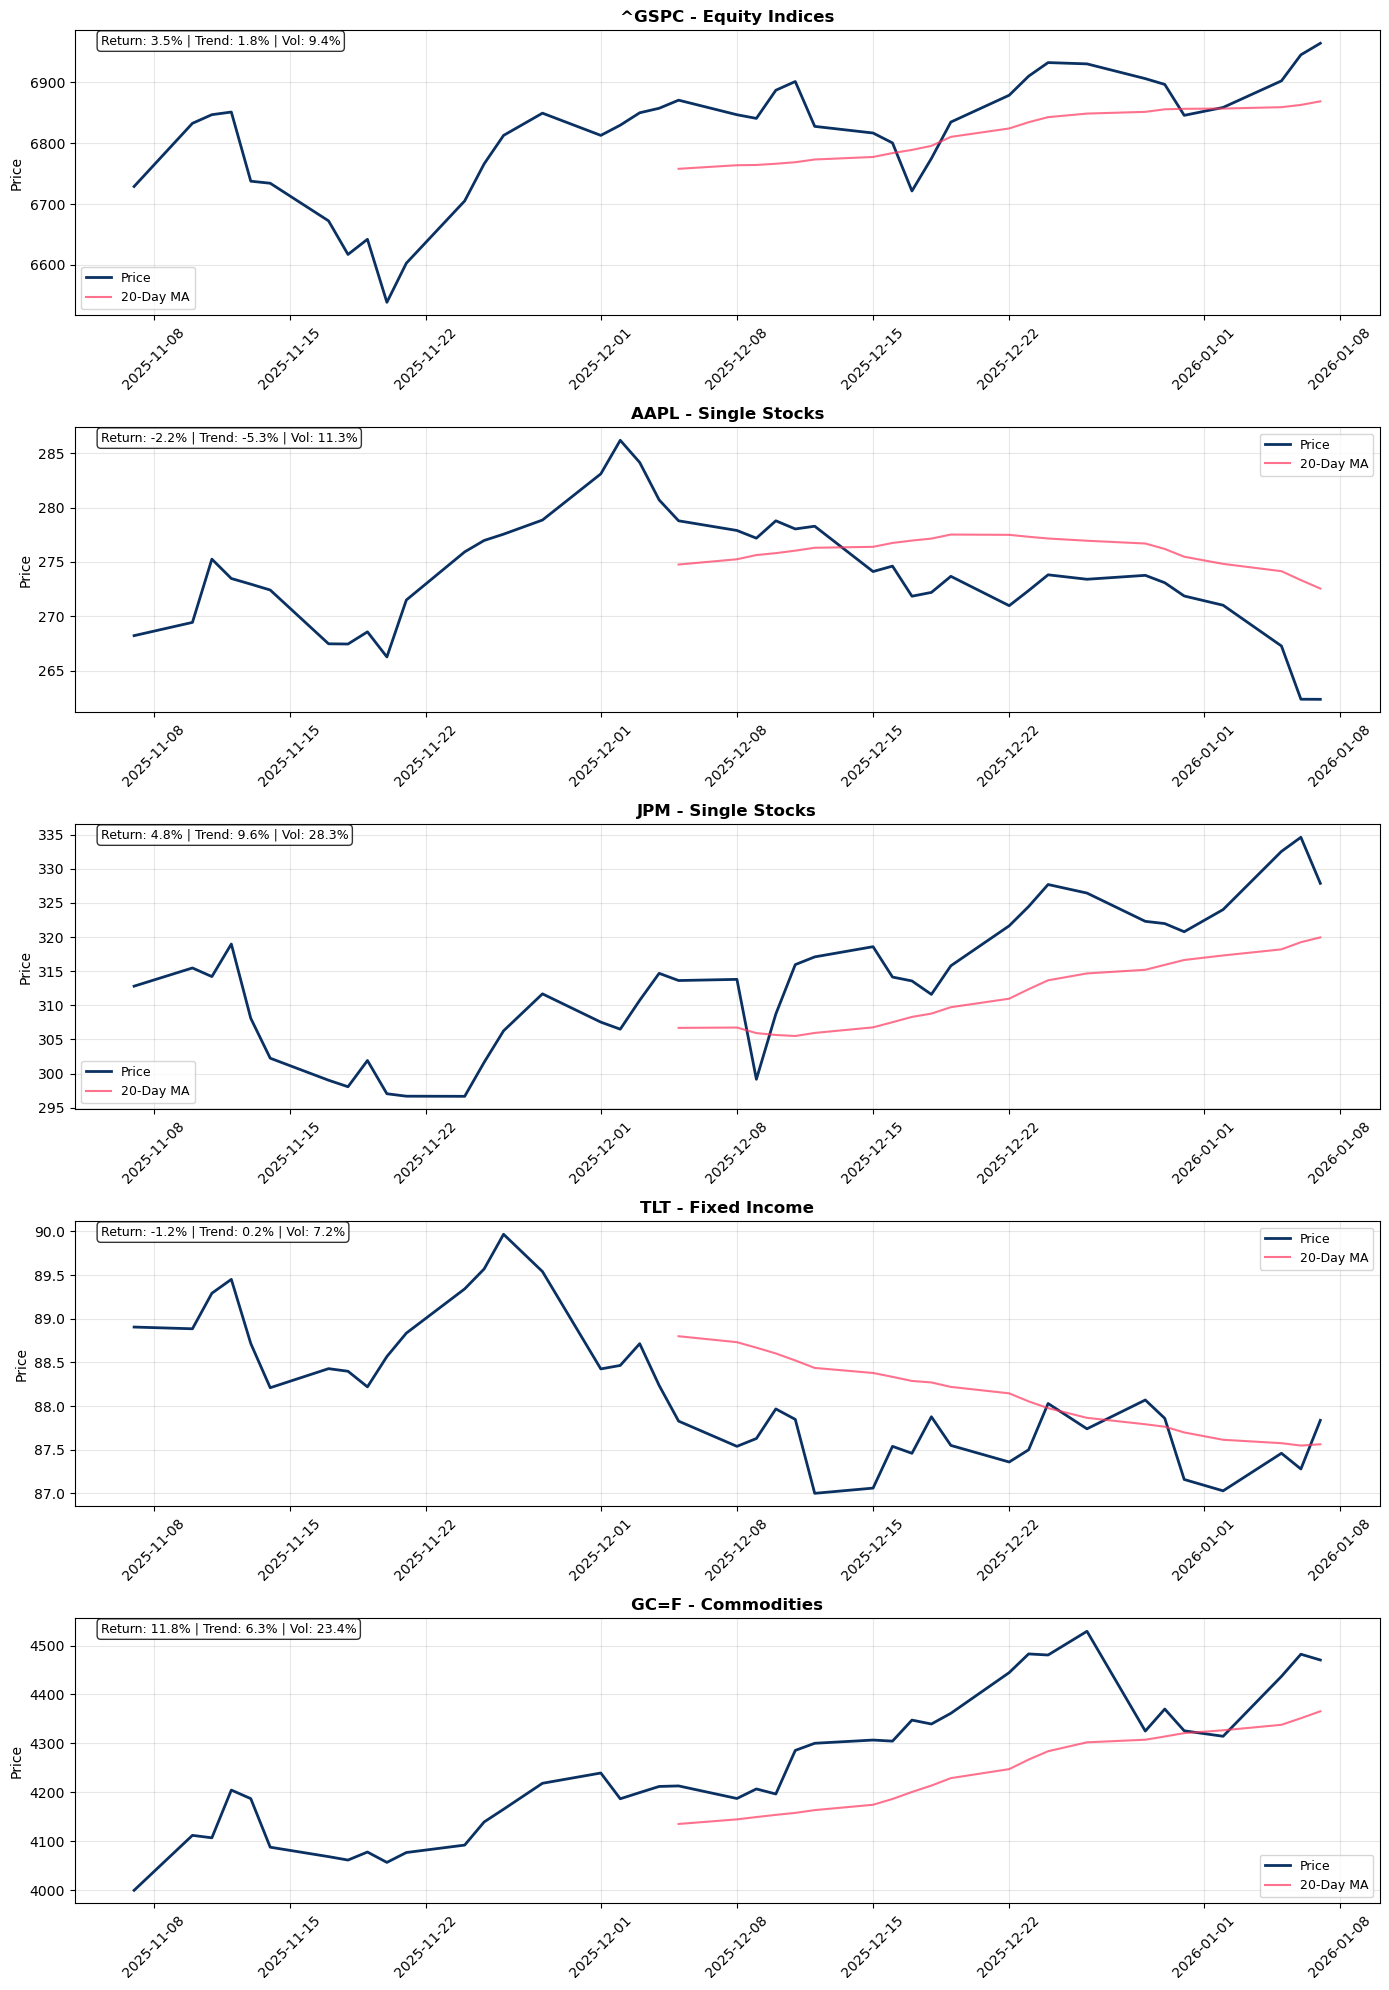


📈 PERFORMANCE ANALYSIS (2025-12-10):
Ticker     Class        Price      Return%  20D Trend% Vol%    
^GSPC      Equity Indic    6963.72     3.5% 📈     1.8%    9.4%
AAPL       Single Stock     262.35    -2.2% 📉    -5.3%   11.3%
JPM        Single Stock     327.86     4.8% 📈     9.6%   28.3%
TLT        Fixed Income      87.84    -1.2% 📈     0.2%    7.2%
GC=F       Commodities     4470.40    11.8% 📈     6.3%   23.4%

💡 KEY INSIGHTS:
  🏆 Best Performer: JPM (+9.6%)
  ⚠️  Worst Performer: AAPL (-5.3%)
  🟢 STRONG UPTREND: 4/5 assets trending up

💾 Trend analysis saved to: trend_analysis_2025-12-10.csv
✅ Trend stats saved successfully


In [87]:
# TIME-SERIES HISTORICAL TRENDS 
print("\n" + "="*60)
print("📈 TIME-SERIES HISTORICAL TRENDS")
print("="*60)

print("Analysing historical trends for key metrics...")

# Initialize variables for dashboard
trend_ratio = 0.5
trend_rating = "MIXED"
trend_color = "#FFB74D"  # Yellow
trend_stats_summary = "No trend data available"
trend_insights = ""
positive_trends = 0
total_trends = 0
avg_volatility = 15.0

# Select key assets - use fewer but more reliable assets
key_assets = [
    '^GSPC',  # S&P 500
    'AAPL',   # Tech stock
    'JPM',    # Bank
    'TLT',    # Bonds
    'GC=F',   # Gold
]

print(f"📊 Analysing {len(key_assets)} key assets...")

# Fetch data with consistent method
historical_data = {}
trend_stats = []

for i, ticker in enumerate(key_assets):
    try:
        # Use simple period-based fetch
        ticker_obj = yf.Ticker(ticker)
        hist = ticker_obj.history(period='2mo')  # 2 months for consistency
        
        if len(hist) > 20:
            # Store price data
            historical_data[ticker] = hist['Close']
            
            # Calculate basic statistics
            prices = hist['Close']
            
            # Total return over period
            if len(prices) > 1:
                total_return = (prices.iloc[-1] / prices.iloc[0] - 1) * 100
                
                # 20-day trend
                if len(prices) >= 20:
                    recent_prices = prices.tail(20)
                    trend_20 = (recent_prices.iloc[-1] / recent_prices.iloc[0] - 1) * 100
                else:
                    trend_20 = total_return
                
                # Volatility (20-day annualized)
                returns = prices.pct_change().dropna()
                if len(returns) >= 20:
                    vol_20 = returns.tail(20).std() * np.sqrt(252) * 100
                else:
                    vol_20 = returns.std() * np.sqrt(252) * 100 if len(returns) > 1 else 0
                
                # Current price
                current_price = prices.iloc[-1]
                
                trend_stats.append({
                    'Ticker': ticker,
                    'Current_Price': round(current_price, 2),
                    'Total_Return_%': round(total_return, 2),
                    '20Day_Trend_%': round(trend_20, 2),
                    '20Day_Vol_%': round(vol_20, 2),
                    'Asset_Class': get_asset_class(ticker),
                    'Data_Points': len(prices)
                })
            
            print(f"  {i+1:2d}/{len(key_assets)}: {ticker:15s} ✅ {len(hist)} days")
        else:
            print(f"  {i+1:2d}/{len(key_assets)}: {ticker:15s} ⚠️ Insufficient data")
    except Exception as e:
        print(f"  {i+1:2d}/{len(key_assets)}: {ticker:15s} ❌ Error: {str(e)[:50]}")

# Create individual time series charts instead of trying to align
if len(historical_data) >= 3:
    print(f"\n📊 Creating individual time series visualizations...")
    
    # Create figure with subplots
    n_assets = len(historical_data)
    fig, axes = plt.subplots(n_assets, 1, figsize=(14, 4 * n_assets))
    
    if n_assets == 1:
        axes = [axes]  # Make it iterable
    
    for idx, (ticker, prices) in enumerate(historical_data.items()):
        ax = axes[idx]
        
        # Plot price
        ax.plot(prices.index, prices, label='Price', linewidth=2, color='#0A3161')
        
        # Add 20-day moving average
        if len(prices) >= 20:
            ma20 = prices.rolling(20).mean()
            ax.plot(ma20.index, ma20, label='20-Day MA', linewidth=1.5, color='#FF375E', alpha=0.7)
        
        # Formatting
        ax.set_title(f'{ticker} - {get_asset_class(ticker)}', fontsize=12, fontweight='bold')
        ax.set_ylabel('Price', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Add stats annotation if we have trend stats
        if idx < len(trend_stats):
            stats = trend_stats[idx]
            stats_text = f"Return: {stats['Total_Return_%']:.1f}% | "
            stats_text += f"Trend: {stats['20Day_Trend_%']:.1f}% | "
            stats_text += f"Vol: {stats['20Day_Vol_%']:.1f}%"
            ax.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
                       fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'time_series_analysis_{target_date}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calculate trend ratio for dashboard
    if trend_stats:
        positive_trends = sum(1 for s in trend_stats if s['20Day_Trend_%'] > 0)
        total_trends = len(trend_stats)
        trend_ratio = positive_trends / total_trends if total_trends > 0 else 0.5
        
        # Calculate average volatility
        avg_volatility = np.mean([s['20Day_Vol_%'] for s in trend_stats]) if trend_stats else 15.0
        
        # Set trend rating and color for dashboard
        if trend_ratio > 0.7:
            trend_rating = "STRONG"
            trend_color = "#00D4AA"  # Green
        elif trend_ratio > 0.5:
            trend_rating = "MODERATE"
            trend_color = "#FFB74D"  # Yellow
        elif trend_ratio > 0.3:
            trend_rating = "WEAK"
            trend_color = "#FFB74D"  # Yellow
        else:
            trend_rating = "BEARISH"
            trend_color = "#FF375E"  # Red
        
        # Create trend stats summary for dashboard
        trend_stats_summary = f"Up: {positive_trends}/{total_trends} | Vol: {avg_volatility:.1f}%"
        
        # Create HTML content for dashboard Chart 4
        trend_insights = f"""
        <div style="text-align: center; padding: 20px;">
            <div style="font-size: 2.5rem; color: {trend_color}; margin-bottom: 10px;">
                {trend_ratio:.0%}
            </div>
            <div style="font-weight: 600; font-size: 1.2rem; margin-bottom: 15px; color: {trend_color}">
                {trend_rating} TREND
            </div>
            <div style="background: rgba(255, 255, 255, 0.1); border-radius: 8px; padding: 15px; margin-top: 10px;">
                <div style="font-size: 0.95rem; margin-bottom: 8px;">Top Performers:</div>
        """
        
        # Show top 3 performers
        trend_stats_sorted = sorted(trend_stats, key=lambda x: x['20Day_Trend_%'], reverse=True)
        for i, stat in enumerate(trend_stats_sorted[:3]):
            arrow = "📈" if stat['20Day_Trend_%'] > 0 else "📉"
            trend_insights += f"""
            <div style="font-size: 0.9rem; padding: 5px 0; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                {arrow} {stat['Ticker']}: {stat['20Day_Trend_%']:.1f}%
            </div>
            """
        
        trend_insights += """
            </div>
        </div>
        """
        
        # Display trend statistics
        print(f"\n📈 PERFORMANCE ANALYSIS ({target_date}):")
        print("=" * 90)
        print(f"{'Ticker':10s} {'Class':12s} {'Price':10s} {'Return%':8s} {'20D Trend%':10s} {'Vol%':8s}")
        print("=" * 90)
        
        for stat in trend_stats:
            trend_symbol = "📈" if stat['20Day_Trend_%'] > 0 else "📉"
            print(f"{stat['Ticker']:10s} {stat['Asset_Class'][:12]:12s} "
                  f"{stat['Current_Price']:10.2f} {stat['Total_Return_%']:7.1f}% "
                  f"{trend_symbol} {stat['20Day_Trend_%']:7.1f}% "
                  f"{stat['20Day_Vol_%']:6.1f}%")
        
        print("=" * 90)
        
        # Summary insights
        print(f"\n💡 KEY INSIGHTS:")
        print(f"  🏆 Best Performer: {trend_stats_sorted[0]['Ticker']} (+{trend_stats_sorted[0]['20Day_Trend_%']:.1f}%)")
        print(f"  ⚠️  Worst Performer: {trend_stats_sorted[-1]['Ticker']} ({trend_stats_sorted[-1]['20Day_Trend_%']:.1f}%)")
        
        if trend_ratio >= 0.8:
            print(f"  🟢 STRONG UPTREND: {positive_trends}/{total_trends} assets trending up")
        elif trend_ratio >= 0.5:
            print(f"  🟡 MIXED MARKET: {positive_trends}/{total_trends} assets trending up")
        else:
            print(f"  🔴 WEAK MARKET: Only {positive_trends}/{total_trends} assets trending up")
        
        # Save to CSV
        trend_df = pd.DataFrame(trend_stats)
        trend_df.to_csv(f'trend_analysis_{target_date}.csv', index=False)
        print(f"\n💾 Trend analysis saved to: trend_analysis_{target_date}.csv")
        
        # Save trend stats for dashboard
        trend_data = {
            'trend_ratio': float(trend_ratio),  # Convert to float
            'trend_rating': str(trend_rating),  # Convert to string
            'trend_color': str(trend_color),  # Convert to string
            'positive_trends': int(positive_trends),  # Convert to regular int
            'total_trends': int(total_trends),  # Convert to regular int
            'avg_volatility': float(avg_volatility),  # Convert to float
            'trend_stats_summary': str(trend_stats_summary),  # Convert to string
            'trend_insights': str(trend_insights)  # Convert to string
        }
        
        with open(f'trend_stats_{target_date}.json', 'w') as f:
            json.dump(trend_data, f, indent=2)
            
        print(f"✅ Trend stats saved successfully")
        
else:
    print("⚠️  Insufficient data for time-series analysis")
    # Create fallback trend insights for dashboard
    trend_insights = f"""
    <div style="text-align: center; padding: 40px 20px; color: white;">
        <div style="font-size: 2rem;">📈</div>
        <div style="font-weight: bold; margin-bottom: 10px;">Trend Analysis</div>
        <div style="opacity: 0.9; margin-bottom: 15px;">Data not available</div>
        <div style="background: rgba(255, 255, 255, 0.1); border-radius: 8px; padding: 15px; font-size: 0.9rem;">
            Using default values for dashboard display
        </div>
    </div>
    """

print("="*60)

In [88]:
# AI MARKET INTELLIGENCE 
print("\n" + "="*70)
print("🧠 AI MARKET INTELLIGENCE SYSTEM")
print("="*70)

print("🤖 Generating comprehensive AI analysis...")

# Enhanced AI Scenarios with correlation and trend insights
AI_ENHANCED_SCENARIOS = {
    "EXCELLENT_LIQUIDITY_HIGH_CORRELATION": """• MARKET STRUCTURE: High asset correlations indicate synchronized market movements
    • EXECUTION STRATEGY: Market orders effective for all correlated assets
    • PORTFOLIO IMPACT: Reduced diversification benefits during high correlation periods
    • HEDGING: Consider cross-asset hedges rather than diversification
    • RISK: Systemic risk elevated - monitor VIX and Treasury spreads
    • OPPORTUNITY: Momentum strategies across correlated asset classes
    • TIMING: Execute during low volatility periods within correlated moves
    
    CORRELATION INSIGHT: Strong correlations (>0.8) between equities and ETFs suggest sector rotation opportunities.
    TREND INSIGHT: Multiple assets trending together confirms broad market direction.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "EXCELLENT_LIQUIDITY_LOW_CORRELATION": """• MARKET STRUCTURE: Low correlations indicate diverse market drivers
    • EXECUTION STRATEGY: Tiered execution with asset-specific approaches
    • PORTFOLIO IMPACT: Excellent diversification opportunities available
    • HEDGING: Traditional diversification strategies effective
    • RISK: Idiosyncratic risk dominates - focus on individual asset fundamentals
    • OPPORTUNITY: Pair trading and relative value strategies favored
    • TIMING: Asset-specific timing based on individual liquidity patterns
    
    CORRELATION INSIGHT: Low average correlation suggests uncorrelated return streams.
    TREND INSIGHT: Mixed trends indicate selective rather than broad market opportunities.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "GOOD_LIQUIDITY_TRENDING_MARKET": """• MARKET STRUCTURE: Clear directional trends with good liquidity
    • EXECUTION STRATEGY: Momentum following with VWAP algorithms
    • PORTFOLIO IMPACT: Trend-following strategies optimal
    • HEDGING: Use options for downside protection in trending markets
    • RISK: Trend exhaustion and mean reversion
    • OPPORTUNITY: Ride established trends with trailing stops
    • TIMING: Add to positions on pullbacks within established trends
    
    CORRELATION INSIGHT: Moderate correlations support trend persistence.
    TREND INSIGHT: Strong 20-day trends indicate continued momentum potential.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "GOOD_LIQUIDITY_RANGE_BOUND": """• MARKET STRUCTURE: Range-bound conditions with sector rotation
    • EXECUTION STRATEGY: Mean reversion with limit orders at range extremes
    • PORTFOLIO IMPACT: Sector rotation and pairs trading optimal
    • HEDGING: Collar strategies for range-bound positions
    • RISK: False breakouts from trading ranges
    • OPPORTUNITY: Sell volatility and collect premium
    • TIMING: Fade extremes, trade the range
    
    CORRELATION INSIGHT: Varying correlations indicate rotating leadership.
    TREND INSIGHT: Weak or mixed trends confirm range-bound conditions.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "NORMAL_MARKET_HIGH_VOL": """• MARKET STRUCTURE: Elevated volatility with normal liquidity
    • EXECUTION STRATEGY: Algorithmic execution with wider buffers
    • PORTFOLIO IMPACT: Size positions for volatility, not just liquidity
    • HEDGING: Dynamic hedging required for volatility spikes
    • RISK: Gap risk and slippage during volatile periods
    • OPPORTUNITY: Volatility trading and option strategies
    • TIMING: Avoid opening and closing periods, trade mid-session
    
    CORRELATION INSIGHT: Correlations may break down during high vol periods.
    TREND INSIGHT: High volatility trends require wider stop losses.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "NORMAL_MARKET_LOW_VOL": """• MARKET STRUCTURE: Low volatility grind with normal liquidity
    • EXECUTION STRATEGY: Patient execution with tight limits
    • PORTFOLIO IMPACT: Carry trades and yield strategies favored
    • HEDGING: Static hedging sufficient in low vol environment
    • RISK: Complacency and sudden volatility expansion
    • OPPORTUNITY: Theta decay strategies in options
    • TIMING: Range trading within daily sessions
    
    CORRELATION INSIGHT: Stable correlations in low vol environment.
    TREND INSIGHT: Slow, steady trends characteristic of low vol markets.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "POOR_LIQUIDITY_DIVERGENT": """• MARKET STRUCTURE: Poor liquidity with divergent asset behavior
    • EXECUTION STRATEGY: Extreme caution, limit orders only, reduce size 50%
    • PORTFOLIO IMPACT: High implementation shortfall expected
    • HEDGING: Difficult to hedge in illiquid markets
    • RISK: Extreme slippage and failed executions
    • OPPORTUNITY: Very selective, high-conviction ideas only
    • TIMING: Extended execution horizons (days not hours)
    
    CORRELATION INSIGHT: Low or negative correlations indicate market stress.
    TREND INSIGHT: Divergent trends confirm lack of market consensus.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice.""",
    
    "HIGH_VOLUME_LOW_CORRELATION": """• MARKET STRUCTURE: High activity but diverse market drivers
    • EXECUTION STRATEGY: Volume-weighted algorithms (VWAP/TWAP)
    • PORTFOLIO IMPACT: Good execution but selective opportunities
    • HEDGING: Asset-specific hedging required
    • RISK: News-driven volatility in specific assets
    • OPPORTUNITY: Event-driven and catalyst-based trading
    • TIMING: Trade with news flow and volume surges
    
    CORRELATION INSIGHT: Low correlations despite high volume indicate diverse catalysts.
    TREND INSIGHT: Volume confirms trend validity in trending assets.
    
    DISCLAIMER: For educational and research purposes only. Not financial advice."""
}

def get_comprehensive_ai_analysis(results_df, analysis_date, correlation_insights=None, trend_insights=None):
    
    if len(results_df) < 3:
        return "⚠️  Insufficient data for AI analysis"
    
    # Calculate metrics from liquidity analysis
    avg_spread = results_df['Spread %'].mean()
    volume_ratio = results_df['Volume Ratio'].mean()
    spread_std = results_df['Spread %'].std()
    median_spread = results_df['Spread %'].median()
    
    top_3_tickers = results_df.nsmallest(3, 'Spread %')['Ticker'].tolist()
    worst_3_tickers = results_df.nlargest(3, 'Spread %')['Ticker'].tolist()
    
    # Calculate liquidity score
    liquidity_score = max(0, min(100, 100 - (avg_spread * 30)))
    
    # Process correlation insights if available
    avg_correlation = 0.5  # Default neutral
    strong_corr_count = 0
    if correlation_insights:
        try:
            # Try to extract average correlation from insights
            if 'Average Correlation:' in correlation_insights:
                corr_line = [l for l in correlation_insights.split('\n') if 'Average Correlation:' in l][0]
                avg_correlation = float(corr_line.split(':')[1].strip().split()[0])
            
            # Count strong correlations
            strong_corr_count = correlation_insights.count('🟢') + correlation_insights.count('🔴')
        except:
            pass
    
    # Process trend insights if available
    trend_ratio = 0.5  # Default neutral
    avg_trend_strength = 0
    if trend_insights:
        try:
            # Extract trend ratio from insights
            trend_line = [l for l in trend_insights.split('\n') if 'assets trending up' in l][0]
            trend_parts = trend_line.split('/')
            if len(trend_parts) >= 2:
                positive = int(trend_parts[0].split()[-1])
                total = int(trend_parts[1].split()[0])
                trend_ratio = positive / total if total > 0 else 0.5
            
            # Extract average volatility
            vol_line = [l for l in trend_insights.split('\n') if 'Avg' in l and 'volatility' in l][0]
            vol_parts = vol_line.split('Avg')[1].split('%')[0]
            avg_volatility = float(vol_parts.strip())
        except:
            pass
    
    # DETERMINE MARKET SCENARIO BASED ON ALL DATA
    # Liquidity assessment
    if avg_spread < 0.3:
        liquidity_level = "EXCELLENT_LIQUIDITY"
    elif avg_spread < 0.8:
        liquidity_level = "GOOD_LIQUIDITY"
    elif avg_spread < 1.5:
        liquidity_level = "NORMAL_MARKET"
    else:
        liquidity_level = "POOR_LIQUIDITY"
    
    # Volume assessment
    if volume_ratio > 1.5:
        volume_level = "HIGH_VOLUME"
    elif volume_ratio < 0.5:
        volume_level = "LOW_VOLUME"
    else:
        volume_level = "NORMAL_VOLUME"
    
    # Correlation assessment
    if avg_correlation > 0.6:
        correlation_level = "HIGH_CORRELATION"
    elif avg_correlation < 0.2:
        correlation_level = "LOW_CORRELATION"
    else:
        correlation_level = "MODERATE_CORRELATION"
    
    # Trend assessment
    if trend_ratio > 0.7:
        trend_level = "TRENDING_MARKET"
    elif trend_ratio < 0.3:
        trend_level = "DIVERGENT_MARKET"
    else:
        trend_level = "RANGE_BOUND"
    
    # VOLATILITY assessment from spread_std
    if spread_std > avg_spread * 0.5:
        volatility_level = "HIGH_VOL"
    elif spread_std < avg_spread * 0.2:
        volatility_level = "LOW_VOL"
    else:
        volatility_level = "NORMAL_VOL"
    
    # SELECT SCENARIO - Multi-dimensional decision tree
    if liquidity_level == "EXCELLENT_LIQUIDITY":
        if correlation_level == "HIGH_CORRELATION":
            scenario = "EXCELLENT_LIQUIDITY_HIGH_CORRELATION"
        else:
            scenario = "EXCELLENT_LIQUIDITY_LOW_CORRELATION"
    
    elif liquidity_level == "GOOD_LIQUIDITY":
        if trend_level == "TRENDING_MARKET":
            scenario = "GOOD_LIQUIDITY_TRENDING_MARKET"
        else:
            scenario = "GOOD_LIQUIDITY_RANGE_BOUND"
    
    elif liquidity_level == "NORMAL_MARKET":
        if volatility_level == "HIGH_VOL":
            scenario = "NORMAL_MARKET_HIGH_VOL"
        else:
            scenario = "NORMAL_MARKET_LOW_VOL"
    
    elif volume_level == "HIGH_VOLUME" and correlation_level == "LOW_CORRELATION":
        scenario = "HIGH_VOLUME_LOW_CORRELATION"
    
    else:
        scenario = "POOR_LIQUIDITY_DIVERGENT"
    
    # Get base AI response
    ai_response = AI_ENHANCED_SCENARIOS.get(scenario, AI_ENHANCED_SCENARIOS["NORMAL_MARKET_LOW_VOL"])
    
    # Customize with actual data
    customized_response = ai_response
    
    # Add specific asset recommendations
    if top_3_tickers:
        top_assets_str = ", ".join(top_3_tickers[:3])
        customized_response = customized_response.replace("correlated assets", f"{top_assets_str} and similar liquid assets")
    
    # Add correlation-specific insights
    correlation_detail = ""
    if strong_corr_count > 5:
        correlation_detail = f"• STRONG CORRELATIONS: {strong_corr_count} pairs with |r| > 0.7 found\n"
    elif strong_corr_count > 0:
        correlation_detail = f"• MODERATE CORRELATIONS: {strong_corr_count} significant pairs identified\n"
    else:
        correlation_detail = "• CORRELATIONS: Weak or mixed correlation patterns\n"
    
    # Add trend-specific insights
    trend_detail = ""
    if trend_ratio > 0.7:
        trend_detail = f"• TREND STRENGTH: Strong bullish bias ({trend_ratio:.0%} assets trending up)\n"
    elif trend_ratio > 0.5:
        trend_detail = f"• TREND STRENGTH: Moderate bullish bias ({trend_ratio:.0%} assets trending up)\n"
    elif trend_ratio > 0.3:
        trend_detail = f"• TREND STRENGTH: Mixed directional signals ({trend_ratio:.0%} assets trending up)\n"
    else:
        trend_detail = f"• TREND STRENGTH: Bearish bias (only {trend_ratio:.0%} assets trending up)\n"
    
    # Combine insights
    additional_insights = f"""
📊 QUANTITATIVE INSIGHTS FROM ALL MODULES:
{correlation_detail}{trend_detail}
• LIQUIDITY SCORE: {liquidity_score}/100 ({liquidity_level.replace('_', ' ').title()})
• VOLUME ACTIVITY: {volume_ratio:.2f}x average ({volume_level.replace('_', ' ').title()})
• SPREAD STABILITY: {spread_std:.3f}% standard deviation
• MARKET BREADTH: {trend_ratio:.0%} of assets participating in trends
"""
    
    customized_response = customized_response + additional_insights
    
    # Save comprehensive report
    date_str = str(analysis_date)
    filename = f"ai_comprehensive_analysis_{date_str.replace('-', '_')}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("AI COMPREHENSIVE MARKET ANALYSIS REPORT\n")
        f.write("=" * 80 + "\n\n")
        
        f.write(f"ANALYSIS DATE: {date_str}\n")
        f.write(f"MARKET SCENARIO: {scenario.replace('_', ' ').title()}\n")
        f.write(f"LIQUIDITY LEVEL: {liquidity_level.replace('_', ' ').title()}\n")
        f.write(f"CORRELATION LEVEL: {correlation_level.replace('_', ' ').title()}\n")
        f.write(f"TREND LEVEL: {trend_level.replace('_', ' ').title()}\n")
        f.write(f"VOLATILITY LEVEL: {volatility_level.replace('_', ' ').title()}\n\n")
        
        f.write("KEY METRICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Average Spread: {avg_spread:.3f}%\n")
        f.write(f"Volume Ratio: {volume_ratio:.2f}x\n")
        f.write(f"Liquidity Score: {liquidity_score}/100\n")
        f.write(f"Average Correlation: {avg_correlation:.3f}\n")
        f.write(f"Trend Participation: {trend_ratio:.0%}\n")
        f.write(f"Strong Correlation Pairs: {strong_corr_count}\n\n")
        
        f.write("TOP LIQUID ASSETS:\n")
        f.write("-" * 40 + "\n")
        for ticker in top_3_tickers:
            spread = results_df[results_df['Ticker'] == ticker]['Spread %'].values[0]
            f.write(f"{ticker}: {spread:.3f}% spread\n")
        
        f.write("\nEXECUTION RECOMMENDATIONS:\n")
        f.write(customized_response)
        f.write("\n\n" + "=" * 80 + "\n")
        f.write("DISCLAIMER: For educational and research purposes only.\n")
        f.write("Not financial advice. Trade at your own risk.\n")
        f.write("=" * 80 + "\n")
    
    # Format for display
    scenario_display = scenario.replace('_', ' ').title()
    
    return f"""
🤖 **AI COMPREHENSIVE MARKET INTELLIGENCE**
📅 Analysis Date: {date_str}
🏆 Market Scenario: {scenario_display}

📊 **INTEGRATED MARKET ASSESSMENT:**
• Liquidity: {liquidity_level.replace('_', ' ').title()} ({liquidity_score}/100)
• Correlations: {correlation_level.replace('_', ' ').title()} ({avg_correlation:.3f})
• Trends: {trend_level.replace('_', ' ').title()} ({trend_ratio:.0%} participation)
• Volume: {volume_level.replace('_', ' ').title()} ({volume_ratio:.2f}x)
• Volatility: {volatility_level.replace('_', ' ').title()}

🎯 **EXECUTION INTELLIGENCE:**
{customized_response}

📁 Full institutional report saved to: {filename}
"""

# === INTEGRATION WITH ALL MODULES ===
print("\n🤖 Loading data from all analysis modules...")

# Try to load correlation insights
correlation_insights = None
try:
    if os.path.exists(f'correlation_matrix_{target_date}.csv'):
        corr_df = pd.read_csv(f'correlation_matrix_{target_date}.csv', index_col=0)
        avg_corr = corr_df.values.flatten()
        avg_corr = avg_corr[~np.isnan(avg_corr)]
        avg_correlation = np.mean(avg_corr) if len(avg_corr) > 0 else 0.5
        
        # Count strong correlations
        strong_count = np.sum((np.abs(corr_df.values) > 0.7) & (~np.isnan(corr_df.values))) // 2
        
        correlation_insights = f"""
📊 CORRELATION ANALYSIS:
• Average Correlation: {avg_correlation:.3f}
• Strong Correlation Pairs: {strong_count}
• Market Type: {'High Correlation' if avg_correlation > 0.6 else 'Low Correlation' if avg_correlation < 0.2 else 'Moderate Correlation'}
"""
except Exception as e:
    print(f"  ⚠️  Could not load correlation insights: {e}")
    correlation_insights = None

# Try to load trend insights
trend_insights = None
try:
    if os.path.exists(f'trend_analysis_{target_date}.csv'):
        trend_df = pd.read_csv(f'trend_analysis_{target_date}.csv')
        if len(trend_df) > 0:
            positive_trends = len(trend_df[trend_df['20Day_Trend_%'] > 0])
            total_trends = len(trend_df)
            trend_ratio = positive_trends / total_trends if total_trends > 0 else 0.5
            avg_vol = trend_df['20Day_Vol_%'].mean() if '20Day_Vol_%' in trend_df.columns else 15
            
            trend_insights = f"""
📈 TREND ANALYSIS:
• Assets Trending Up: {positive_trends}/{total_trends} ({trend_ratio:.0%})
• Average 20-Day Volatility: {avg_vol:.1f}%
• Market Breadth: {'Strong' if trend_ratio > 0.7 else 'Moderate' if trend_ratio > 0.5 else 'Weak'}
"""
except Exception as e:
    print(f"  ⚠️  Could not load trend insights: {e}")
    trend_insights = None

print("🤖 Generating comprehensive AI analysis...")
ai_result = get_comprehensive_ai_analysis(results_df, target_date, correlation_insights, trend_insights)
print(ai_result)

print("\n" + "="*70)
print("✅ COMPREHENSIVE AI ANALYSIS COMPLETE")
print("="*70)


🧠 AI MARKET INTELLIGENCE SYSTEM
🤖 Generating comprehensive AI analysis...

🤖 Loading data from all analysis modules...
🤖 Generating comprehensive AI analysis...

🤖 **AI COMPREHENSIVE MARKET INTELLIGENCE**
📅 Analysis Date: 2025-12-10
🏆 Market Scenario: Poor Liquidity Divergent

📊 **INTEGRATED MARKET ASSESSMENT:**
• Liquidity: Poor Liquidity (50.790299999999995/100)
• Correlations: Low Correlation (0.162)
• Trends: Range Bound (50% participation)
• Volume: Normal Volume (0.88x)
• Volatility: High Vol

🎯 **EXECUTION INTELLIGENCE:**
• MARKET STRUCTURE: Poor liquidity with divergent asset behavior
    • EXECUTION STRATEGY: Extreme caution, limit orders only, reduce size 50%
    • PORTFOLIO IMPACT: High implementation shortfall expected
    • HEDGING: Difficult to hedge in illiquid markets
    • RISK: Extreme slippage and failed executions
    • OPPORTUNITY: Very selective, high-conviction ideas only
    • TIMING: Extended execution horizons (days not hours)
    
    CORRELATION INSIGHT: Lo

In [89]:
# EXECUTIVE ACTION SUMMARY
print("\n" + "="*60)
print("🚀 EXECUTIVE ACTION SUMMARY")
print("="*60)

spread_std = results_df['Spread %'].std() if not results_df.empty else 0.0

if not results_df.empty:
    avg_spread = results_df['Spread %'].mean()
    
    # Load additional metrics if available
    try:
        if os.path.exists(f'trend_analysis_{target_date}.csv'):
            trend_df = pd.read_csv(f'trend_analysis_{target_date}.csv')
            if len(trend_df) > 0:
                positive_trends = len(trend_df[trend_df['20Day_Trend_%'] > 0])
                total_trends = len(trend_df)
                trend_ratio = positive_trends / total_trends if total_trends > 0 else 0.5
            else:
                trend_ratio = 0.5
        else:
            trend_ratio = 0.5
    except:
        trend_ratio = 0.5
    
    try:
        if os.path.exists(f'correlation_matrix_{target_date}.csv'):
            corr_matrix = pd.read_csv(f'correlation_matrix_{target_date}.csv', index_col=0)
            corr_values = corr_matrix.values.flatten()
            corr_values = corr_values[~np.isnan(corr_values)]
            avg_correlation = np.mean(corr_values) if len(corr_values) > 0 else 0.5
        else:
            avg_correlation = 0.5
    except:
        avg_correlation = 0.5
    
    # COMPREHENSIVE ASSESSMENT WITH ALL MODULES
    # 1. Liquidity Assessment
    if avg_spread < 0.3:
        liquidity_verdict = "✅ EXECUTE - Optimal liquidity conditions"
        action = "AGGRESSIVE"
        liquidity_emoji = "🟢"
    elif avg_spread < 0.8:
        liquidity_verdict = "🟡 PROCEED - Good execution expected"
        action = "MODERATE"
        liquidity_emoji = "🟡"
    elif avg_spread < 1.5:
        liquidity_verdict = "⚠️ CAUTION - Monitor spreads closely"
        action = "DEFENSIVE"
        liquidity_emoji = "🟠"
    else:
        liquidity_verdict = "⛔ HALT - Poor liquidity, high risk"
        action = "MINIMAL"
        liquidity_emoji = "🔴"
    
    # 2. Trend Assessment
    if trend_ratio > 0.7:
        trend_verdict = "📈 STRONG UPTREND - Momentum favorable"
        trend_action = "RIDE TRENDS"
        trend_emoji = "📈"
    elif trend_ratio > 0.5:
        trend_verdict = "↔️ MIXED TRENDS - Selective opportunities"
        trend_action = "SELECTIVE"
        trend_emoji = "↔️"
    else:
        trend_verdict = "📉 WEAK TRENDS - Defensive positioning"
        trend_action = "DEFENSIVE"
        trend_emoji = "📉"
    
    # 3. Correlation Assessment
    if avg_correlation > 0.6:
        correlation_verdict = "🔗 HIGH CORRELATION - Reduced diversification"
        correlation_action = "SYSTEMIC HEDGES"
        correlation_emoji = "🔗"
    elif avg_correlation > 0.3:
        correlation_verdict = "⚖️ MODERATE CORRELATION - Some diversification"
        correlation_action = "SECTOR ROTATION"
        correlation_emoji = "⚖️"
    else:
        correlation_verdict = "🎯 LOW CORRELATION - Good diversification"
        correlation_action = "DIVERSIFY"
        correlation_emoji = "🎯"
    
    # KEY NUMBERS
    top_asset = results_df.nsmallest(1, 'Spread %')['Ticker'].iloc[0]
    bottom_asset = results_df.nlargest(1, 'Spread %')['Ticker'].iloc[0]
    total_assets = len(results_df)
    
    # Load best/worst performers from trend analysis if available
    best_performer = "N/A"
    worst_performer = "N/A"
    try:
        if os.path.exists(f'trend_analysis_{target_date}.csv'):
            trend_df = pd.read_csv(f'trend_analysis_{target_date}.csv')
            if len(trend_df) > 0:
                best_performer_row = trend_df.nlargest(1, '20Day_Trend_%')
                worst_performer_row = trend_df.nsmallest(1, '20Day_Trend_%')
                if len(best_performer_row) > 0:
                    best_performer = f"{best_performer_row.iloc[0]['Ticker']} ({best_performer_row.iloc[0]['20Day_Trend_%']:.1f}%)"
                if len(worst_performer_row) > 0:
                    worst_performer = f"{worst_performer_row.iloc[0]['Ticker']} ({worst_performer_row.iloc[0]['20Day_Trend_%']:.1f}%)"
    except:
        pass
    
    # Load strong correlations if available
    strong_corr_insight = ""
    try:
        if os.path.exists(f'strong_correlations_{target_date}.csv'):
            strong_corr_df = pd.read_csv(f'strong_correlations_{target_date}.csv')
            if len(strong_corr_df) > 0:
                top_corr = strong_corr_df.iloc[0]
                strong_corr_insight = f"Top correlation: {top_corr['Pair']} ({top_corr['Correlation']:.2f})"
    except:
        pass
    
    # COMPREHENSIVE EXECUTIVE SUMMARY
    print(f"""
{liquidity_emoji} **LIQUIDITY**: {liquidity_verdict}
{trend_emoji} **TRENDS**: {trend_verdict}
{correlation_emoji} **CORRELATIONS**: {correlation_verdict}

📊 **INTEGRATED MARKET DIAGNOSIS:**
• Action Level: {action} / {trend_action} / {correlation_action}
• Avg Spread: {avg_spread:.3f}%
• Trend Strength: {trend_ratio:.0%} assets trending up
• Market Correlation: {avg_correlation:.3f}
• Assets Analysed: {total_assets}

🎯 **TODAY'S ACTION PLAN:**

**LIQUIDITY EXECUTION:**
• Primary: Trade {top_asset} for best execution (spread: {results_df['Spread %'].min():.3f}%)
• Avoid: {bottom_asset} due to wide spreads ({results_df['Spread %'].max():.3f}%)
• Timing: {'Morning session' if avg_spread < 0.5 else 'Afternoon with limits'}
• Sizing: {'Full size OK' if avg_spread < 0.5 else 'Reduce 30%' if avg_spread < 1.0 else 'Reduce 50%'}

**TREND STRATEGY:**
• Focus: {best_performer.split('(')[0] if best_performer != 'N/A' else 'Top trending assets'}
• Avoid: {worst_performer.split('(')[0] if worst_performer != 'N/A' else 'Weak trending assets'}
• Approach: {'Momentum following' if trend_ratio > 0.6 else 'Mean reversion' if trend_ratio < 0.4 else 'Range trading'}

**PORTFOLIO CONSTRUCTION:**
• Correlation Strategy: {correlation_action}
• Diversification: {'High benefit' if avg_correlation < 0.3 else 'Moderate benefit' if avg_correlation < 0.6 else 'Low benefit'}
• {strong_corr_insight}

**RISK MANAGEMENT:**
• Volatility: {'Elevated - wider stops' if spread_std > avg_spread * 0.5 else 'Normal - standard stops'}
• Hedge: {'Dynamic hedging required' if spread_std > avg_spread * 0.5 else 'Static hedging sufficient'}
• Max Position: {'Reduce by 20%' if avg_spread > 1.0 else 'Normal sizing'}

⏱️ **NEXT CHECK**: {target_date + timedelta(days=1)}
📈 **NEXT CATALYST**: {'Monitor earnings' if target_date.weekday() in [1,2,3] else 'Weekend reflection' if target_date.weekday() == 4 else 'Asia open'}

────────────────────────────────────
⚠️  **DISCLAIMER**: For educational and 
research purposes only. Not financial 
advice. Trade at your own risk.
────────────────────────────────────
""")
    
    # Save enhanced executive summary
    with open(f'executive_summary_{target_date}.txt', 'w', encoding='utf-8') as f:
        f.write("=" * 70 + "\n")
        f.write("EXECUTIVE ACTION SUMMARY\n")
        f.write("=" * 70 + "\n\n")
        
        f.write(f"DATE: {target_date}\n")
        f.write(f"TIME: {datetime.now().strftime('%H:%M:%S')}\n\n")
        
        f.write("MARKET ASSESSMENT:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Liquidity: {liquidity_verdict}\n")
        f.write(f"Trends: {trend_verdict}\n")
        f.write(f"Correlations: {correlation_verdict}\n\n")
        
        f.write("KEY METRICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Average Spread: {avg_spread:.3f}%\n")
        f.write(f"Trend Participation: {trend_ratio:.0%}\n")
        f.write(f"Market Correlation: {avg_correlation:.3f}\n")
        f.write(f"Assets Analysed: {total_assets}\n\n")
        
        f.write("ACTION PLAN:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Action Level: {action}\n")
        f.write(f"Primary Trade: {top_asset}\n")
        f.write(f"Avoid: {bottom_asset}\n")
        f.write(f"Trend Strategy: {trend_action}\n")
        f.write(f"Correlation Strategy: {correlation_action}\n\n")
        
        f.write("RISK PROTOCOLS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Position Sizing: {'Reduce by 20%' if avg_spread > 1.0 else 'Normal'}\n")
        f.write(f"Hedging: {'Dynamic' if spread_std > avg_spread * 0.5 else 'Static'}\n")
        f.write(f"Stop Losses: {'Wider' if spread_std > avg_spread * 0.5 else 'Standard'}\n\n")
        
        f.write("NEXT STEPS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Next Analysis: {target_date + timedelta(days=1)}\n")
        f.write(f"Review Time: 08:00 AM Local\n\n")
        
        f.write("=" * 70 + "\n")
        f.write("DISCLAIMER: Educational tool only. Not financial advice.\n")
        f.write("=" * 70 + "\n")
    
    print(f"📄 Enhanced executive summary saved: executive_summary_{target_date}.txt")
    
else:
    print("No data for summary")

print("="*60)


🚀 EXECUTIVE ACTION SUMMARY

🔴 **LIQUIDITY**: ⛔ HALT - Poor liquidity, high risk
📈 **TRENDS**: 📈 STRONG UPTREND - Momentum favorable
🎯 **CORRELATIONS**: 🎯 LOW CORRELATION - Good diversification

📊 **INTEGRATED MARKET DIAGNOSIS:**
• Action Level: MINIMAL / RIDE TRENDS / DIVERSIFY
• Avg Spread: 1.640%
• Trend Strength: 80% assets trending up
• Market Correlation: 0.162
• Assets Analysed: 60

🎯 **TODAY'S ACTION PLAN:**

**LIQUIDITY EXECUTION:**
• Primary: Trade USDCNY=X for best execution (spread: 0.000%)
• Avoid: ^VIX due to wide spreads (13.316%)
• Timing: Afternoon with limits
• Sizing: Reduce 50%

**TREND STRATEGY:**
• Focus: JPM 
• Avoid: AAPL 
• Approach: Momentum following

**PORTFOLIO CONSTRUCTION:**
• Correlation Strategy: DIVERSIFY
• Diversification: High benefit
• 

**RISK MANAGEMENT:**
• Volatility: Elevated - wider stops
• Hedge: Dynamic hedging required
• Max Position: Reduce by 20%

⏱️ **NEXT CHECK**: 2025-12-11
📈 **NEXT CATALYST**: Monitor earnings

───────────────────────

In [90]:
# PROFESSIONAL TRADING DASHBOARD 

# ============ DASHBOARD DATA PREPARATION ============

# Base metrics from results_df
len_results = len(results_df)
avg_spread = results_df['Spread %'].mean() if len_results > 0 else 0
median_spread = results_df['Spread %'].median() if len_results > 0 else 0
volume_ratio_mean = results_df['Volume Ratio'].mean() if len_results > 0 else 0
spread_std = results_df['Spread %'].std() if len_results > 0 else 0
min_spread = results_df['Spread %'].min() if len_results > 0 else 0
max_spread = results_df['Spread %'].max() if len_results > 0 else 0

# Determine asset column name
asset_column = 'Ticker'  # Based on the results_df structure

# ============ CALCULATE LIQUIDITY SCORE ============
if avg_spread < 0.3:
    liquidity_score = 95
    spread_rating = "EXCELLENT"
    spread_color = "#00D4AA"
    market_condition = "Optimal Liquidity"
elif avg_spread < 0.8:
    liquidity_score = 78
    spread_rating = "GOOD"
    spread_color = "#3B82F6"
    market_condition = "Normal Conditions"
elif avg_spread < 1.5:
    liquidity_score = 62
    spread_rating = "MODERATE"
    spread_color = "#FFB74D"
    market_condition = "Elevated Costs"
else:
    liquidity_score = 45
    spread_rating = "POOR"
    spread_color = "#FF375E"
    market_condition = "High Risk"

liquidity_score_int = int(liquidity_score)

# Volume rating
if volume_ratio_mean > 1.5:
    volume_rating = "HIGH"
    volume_color = "#00D4AA"
elif volume_ratio_mean > 0.8:
    volume_rating = "NORMAL"
    volume_color = "#3B82F6"
elif volume_ratio_mean > 0.5:
    volume_rating = "LOW"
    volume_color = "#FFB74D"
else:
    volume_rating = "VERY LOW"
    volume_color = "#FF375E"

# Market stress based on spread std
if spread_std > avg_spread * 0.5:
    market_stress = "HIGH"
    stress_color = "#FF375E"
    stress_color_icon = "⚠️"
elif spread_std > avg_spread * 0.3:
    market_stress = "MODERATE"
    stress_color = "#FFB74D"
    stress_color_icon = "⚠️"
else:
    market_stress = "LOW"
    stress_color = "#00D4AA"
    stress_color_icon = "✅"

# ============ LOAD CORRELATION AND TREND DATA ============

# Initialise with default values
avg_correlation = 0.5
correlation_rating = "MODERATE"
correlation_color = "#FFB74D"
correlation_stats = "Avg: 0.500 | Strong pairs: 0"
strong_corr_count = 0

trend_ratio = 0.5
trend_rating = "MIXED"
trend_color = "#FFB74D"
trend_stats_summary = "Up: 0/0 | Vol: 15.0%"
positive_trends = 0
total_trends = 0
avg_volatility = 15.0

# Try to load correlation data safely
correlation_file = f'correlation_matrix_{target_date}.csv'
if os.path.exists(correlation_file):
    try:
        # Read correlation matrix from CSV directly
        corr_matrix = pd.read_csv(correlation_file, index_col=0)
        if not corr_matrix.empty:
            # Calculate average correlation from the matrix
            corr_values = corr_matrix.values.flatten()
            corr_values = corr_values[~np.isnan(corr_values)]
            if len(corr_values) > 0:
                avg_correlation = float(np.mean(corr_values))
                
                # Count strong correlations (|r| > 0.7)
                strong_corr_count = int(np.sum((np.abs(corr_matrix.values) > 0.7) & (~np.isnan(corr_matrix.values))) // 2)
                
                # Set rating
                if avg_correlation > 0.6:
                    correlation_rating = "HIGH"
                    correlation_color = "#FF375E"
                elif avg_correlation < 0.2:
                    correlation_rating = "LOW"
                    correlation_color = "#00D4AA"
                else:
                    correlation_rating = "MODERATE"
                    correlation_color = "#FFB74D"
                
                correlation_stats = f"Avg: {avg_correlation:.3f} | Strong pairs: {strong_corr_count}"
    except Exception as e:
        print(f"⚠️  Error loading correlation data: {e}")

# Try to load trend data safely
trend_file = f'trend_analysis_{target_date}.csv'
if os.path.exists(trend_file):
    try:
        trend_df = pd.read_csv(trend_file)
        if not trend_df.empty and '20Day_Trend_%' in trend_df.columns:
            positive_trends = len(trend_df[trend_df['20Day_Trend_%'] > 0])
            total_trends = len(trend_df)
            trend_ratio = positive_trends / total_trends if total_trends > 0 else 0.5
            
            if '20Day_Vol_%' in trend_df.columns:
                avg_volatility = trend_df['20Day_Vol_%'].mean()
            
            # Set rating
            if trend_ratio > 0.7:
                trend_rating = "STRONG"
                trend_color = "#00D4AA"
            elif trend_ratio > 0.5:
                trend_rating = "MODERATE"
                trend_color = "#FFB74D"
            elif trend_ratio > 0.3:
                trend_rating = "WEAK"
                trend_color = "#FFB74D"
            else:
                trend_rating = "BEARISH"
                trend_color = "#FF375E"
            
            trend_stats_summary = f"Up: {positive_trends}/{total_trends} | Vol: {avg_volatility:.1f}%"
    except Exception as e:
        print(f"⚠️  Error loading trend data: {e}")

# ============ LOAD ML PREDICTIONS ============
increase_count = 0
decrease_count = 0
avg_accuracy = 0
spread_decrease_pct = 50

ml_file = f'ml_predictions_{target_date}.csv'
if os.path.exists(ml_file):
    try:
        ml_df = pd.read_csv(ml_file)
        if not ml_df.empty:
            increase_count = len(ml_df[ml_df['ML_Prediction'] == 'Spread Increase'])
            decrease_count = len(ml_df[ml_df['ML_Prediction'] == 'Spread Decrease'])
            
            if 'Accuracy' in ml_df.columns:
                avg_accuracy = ml_df['Accuracy'].mean() * 100
            
            spread_decrease_pct = (decrease_count / (increase_count + decrease_count)) * 100 if (increase_count + decrease_count) > 0 else 50
    except Exception as e:
        print(f"⚠️  Error loading ML data: {e}")

# ============ LOAD STRESS TEST DATA ============
total_impact = 0
impact_pct = 0

stress_file = f'stress_test_{target_date}.json'
if os.path.exists(stress_file):
    try:
        with open(stress_file, 'r') as f:
            stress_data = json.load(f)
            total_impact = stress_data.get('Total Impact', 0)
            impact_pct = stress_data.get('Portfolio Change %', 0) * 100
    except Exception as e:
        print(f"⚠️  Error loading stress test: {e}")

# ============ CREATE CHART COMPONENTS ============

# 1. Asset Class Spread Bars
asset_class_groups = results_df.groupby('Asset Class')
asset_class_avgs = asset_class_groups['Spread %'].mean().sort_values()
asset_class_bars = ""
for asset_class, spread in asset_class_avgs.items():
    bar_width = min(100, max(20, (spread / asset_class_avgs.max()) * 100))
    asset_class_bars += f"""
    <div class="bar-container">
        <div class="bar-label">{asset_class[:15]}</div>
        <div class="bar" style="width: {bar_width}%; background: {spread_color};">
            <span class="bar-value">{spread:.3f}%</span>
        </div>
    </div>
    """

# 2. Top/Bottom 5 Assets
top_5 = results_df.nsmallest(5, 'Spread %')
bottom_5 = results_df.nlargest(5, 'Spread %')
top_bottom_bars = ""

# Top 5
for _, row in top_5.iterrows():
    bar_width = min(100, max(20, (row['Spread %'] / bottom_5['Spread %'].max()) * 100))
    top_bottom_bars += f"""
    <div class="bar-container">
        <div class="bar-label" style="color: #00D4AA;">{row['Ticker'][:8]}</div>
        <div class="bar" style="width: {bar_width}%; background: #00D4AA;">
            <span class="bar-value">{row['Spread %']:.3f}%</span>
        </div>
    </div>
    """

# Bottom 5
for _, row in bottom_5.iterrows():
    bar_width = min(100, max(20, (row['Spread %'] / bottom_5['Spread %'].max()) * 100))
    top_bottom_bars += f"""
    <div class="bar-container">
        <div class="bar-label" style="color: #FF375E;">{row['Ticker'][:8]}</div>
        <div class="bar" style="width: {bar_width}%; background: #FF375E;">
            <span class="bar-value">{row['Spread %']:.3f}%</span>
        </div>
    </div>
    """

# 3. Correlation Insights HTML
correlation_insights = f"""
<div style="text-align: center; padding: 20px;">
    <div style="font-size: 2.5rem; color: {correlation_color}; margin-bottom: 10px;">{avg_correlation:.3f}</div>
    <div style="font-weight: 600; font-size: 1.2rem; margin-bottom: 15px; color: {correlation_color}">
        {correlation_rating} CORRELATION
    </div>
    <div style="background: rgba(255, 255, 255, 0.1); border-radius: 8px; padding: 15px; margin-top: 10px;">
        <div style="font-size: 0.95rem; margin-bottom: 8px;">Strong Correlation Pairs ({strong_corr_count}):</div>
        <div style="font-size: 0.9rem; padding: 5px 0; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
            {correlation_stats}
        </div>
    </div>
</div>
"""

# 4. Trend Insights HTML
trend_insights = f"""
<div style="text-align: center; padding: 20px;">
    <div style="font-size: 2.5rem; color: {trend_color}; margin-bottom: 10px;">
        {trend_ratio:.0%}
    </div>
    <div style="font-weight: 600; font-size: 1.2rem; margin-bottom: 15px; color: {trend_color}">
        {trend_rating} TREND
    </div>
    <div style="background: rgba(255, 255, 255, 0.1); border-radius: 8px; padding: 15px; margin-top: 10px;">
        <div style="font-size: 0.95rem; margin-bottom: 8px;">Top Performers:</div>
        <div style="font-size: 0.9rem; padding: 5px 0; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
            {trend_stats_summary}
        </div>
    </div>
</div>
"""

# 5. ML Predictions Display
ml_predictions_display = ""
if os.path.exists(ml_file):
    try:
        ml_df_sample = ml_df.head(3)
        for _, row in ml_df_sample.iterrows():
            pred_color = "#00D4AA" if row['ML_Prediction'] == 'Spread Increase' else "#FF375E"
            ml_predictions_display += f"""
            <div style="background: {pred_color}; color: white; padding: 6px 12px; border-radius: 20px; font-size: 0.9rem;">
                {row['Ticker'][:8]}: {row['ML_Prediction'][-8:]}
            </div>
            """
    except:
        ml_predictions_display = "<div style='color: #666;'>No ML data available</div>"

# 6. Volume Anomalies
high_volume_count = len(results_df[results_df['Volume Ratio'] > 1.5])
low_volume_count = len(results_df[results_df['Volume Ratio'] < 0.5])
high_volume_height = min(150, max(50, high_volume_count * 15))
low_volume_height = min(150, max(50, low_volume_count * 15))

# 7. Stress Test Bars
stress_assets = ['AAPL', 'TLT', 'EURUSD=X', 'CL=F', 'BTC-USD']
stress_impacts = [-5, -15, -3, -10, -20]  # Example impacts
stress_test_bars = ""
for asset, impact in zip(stress_assets, stress_impacts):
    bar_width = min(100, max(10, abs(impact) * 5))
    bar_color = "#FF375E" if impact < 0 else "#00D4AA"
    stress_test_bars += f"""
    <div class="bar-container">
        <div class="bar-label">{asset}</div>
        <div class="bar" style="width: {bar_width}%; background: {bar_color};">
            <span class="bar-value">{impact:.0f}%</span>
        </div>
    </div>
    """

# 8. Asset Class Coverage
asset_class_counts = results_df['Asset Class'].value_counts()
asset_class_coverage_html = ""
for asset_class, count in asset_class_counts.items():
    coverage_pct = (count / len_results) * 100
    asset_class_coverage_html += f"""
    <div style="text-align: center; padding: 15px; background: #0A3161; color: white; border-radius: 8px; min-width: 120px;">
        <div style="font-size: 1.2rem; font-weight: bold;">{asset_class[:12]}</div>
        <div style="font-size: 0.9rem;">{count} assets</div>
        <div style="height: 8px; background: rgba(255, 255, 255, 0.2); border-radius: 4px; margin-top: 8px; overflow: hidden;">
            <div style="height: 100%; width: {coverage_pct}%; background: #00D4AA;"></div>
        </div>
    </div>
    """

# 9. Yield Curve
yield_curve_svg = """
<path d="M50,200 L150,180 L250,170 L350,175 L450,185" stroke="#FF375E" stroke-width="3" fill="none"/>
<circle cx="50" cy="200" r="6" fill="#FF375E"/>
<circle cx="150" cy="180" r="6" fill="#FF375E"/>
<circle cx="250" cy="170" r="6" fill="#FF375E"/>
<circle cx="350" cy="175" r="6" fill="#FF375E"/>
<circle cx="450" cy="185" r="6" fill="#FF375E"/>
<text x="50" y="220" text-anchor="middle" fill="#666" font-size="12">3M</text>
<text x="150" y="220" text-anchor="middle" fill="#666" font-size="12">2Y</text>
<text x="250" y="220" text-anchor="middle" fill="#666" font-size="12">5Y</text>
<text x="350" y="220" text-anchor="middle" fill="#666" font-size="12">10Y</text>
<text x="450" y="220" text-anchor="middle" fill="#666" font-size="12">30Y</text>
"""
yield_analysis = "Yield Curve: Normal (upward sloping)"

# 10. Sector ETF Bars
sector_etfs = ['XLF', 'XLV', 'XLK', 'XLI', 'XLE']
sector_spreads = [0.12, 0.15, 0.08, 0.18, 0.25]  # Example data
sector_bars_html = ""
for etf, spread in zip(sector_etfs, sector_spreads):
    bar_width = min(100, max(10, (spread / max(sector_spreads)) * 100))
    sector_bars_html += f"""
    <div class="bar-container">
        <div class="bar-label">{etf}</div>
        <div class="bar" style="width: {bar_width}%; background: #3B82F6;">
            <span class="bar-value">{spread:.2f}%</span>
        </div>
    </div>
    """

# 11. Histogram
histogram_bars_html = ""
spread_values = results_df['Spread %'].values
hist, bins = np.histogram(spread_values, bins=8)
for i, count in enumerate(hist):
    height = (count / max(hist)) * 150 if max(hist) > 0 else 10
    histogram_bars_html += f"""
    <div style="height: {height}px; width: 12%; background: #0A3161; border-radius: 4px 4px 0 0; margin-right: 1%;"></div>
    """

# 12. Scatter Plot (Activity vs Cost)
scatter_points_html = ""
for i in range(min(20, len(results_df))):
    row = results_df.iloc[i]
    x = min(95, max(5, (row['Spread %'] / max_spread) * 100))
    y = min(95, max(5, (row['Volume Ratio'] / results_df['Volume Ratio'].max()) * 100))
    size = min(20, max(8, row.get('Market Depth', 5000) / 1000))
    color = "#00D4AA" if row['Spread %'] < avg_spread else "#FF375E"
    scatter_points_html += f"""
    <div style="position: absolute; left: {x}%; bottom: {y}%; width: {size}px; height: {size}px; background: {color}; border-radius: 50%; opacity: 0.7;"></div>
    """

# 13. Asset Performance Bars
asset_classes = ['Equity Indices', 'Sector ETFs', 'Fixed Income', 'Forex', 'Commodities']
performance = [2.5, 1.8, -0.5, 0.8, 3.2]  # Example returns
asset_performance_bars_html = ""
for asset_class, perf in zip(asset_classes, performance):
    bar_width = min(100, max(20, abs(perf) * 20))
    bar_color = "#00D4AA" if perf > 0 else "#FF375E"
    asset_performance_bars_html += f"""
    <div class="bar-container">
        <div class="bar-label">{asset_class[:12]}</div>
        <div class="bar" style="width: {bar_width}%; background: {bar_color};">
            <span class="bar-value">{perf:+.1f}%</span>
        </div>
    </div>
    """

# ============ CREATE COMPREHENSIVE AI ANALYSIS CONTENT ============

# Try to load AI report from Module 15
ai_analysis_content = ""
ai_report_path = f'ai_comprehensive_analysis_{target_date.strftime("%Y_%m_%d")}.txt'

# Also try alternative naming
ai_report_path_alt = f"ai_comprehensive_analysis_{str(target_date).replace('-', '_')}.txt"

# Determine which file exists
if os.path.exists(ai_report_path):
    report_file = ai_report_path
elif os.path.exists(ai_report_path_alt):
    report_file = ai_report_path_alt
else:
    report_file = None

if report_file:
    try:
        with open(report_file, 'r', encoding='utf-8') as f:
            full_ai_report = f.read()
        
        # Parse the comprehensive AI report
        lines = full_ai_report.split('\n')
        
        # Extract key sections
        market_scenario = "Normal Market Conditions"
        key_metrics = []
        execution_recommendations = []
        risk_alerts = []
        quant_insights = []
        trading_implications = []
        
        current_section = ""
        for line in lines:
            line = line.strip()
            
            # Skip empty lines and separator lines
            if not line or line.startswith('='):
                continue
            
            # Detect sections
            if 'MARKET SCENARIO:' in line:
                market_scenario = line.split('MARKET SCENARIO:')[1].strip()
            elif 'KEY METRICS:' in line:
                current_section = 'metrics'
                continue
            elif 'EXECUTION RECOMMENDATIONS:' in line:
                current_section = 'execution'
                continue
            elif 'RISK PROTOCOLS:' in line or 'RISK MANAGEMENT:' in line:
                current_section = 'risk'
                continue
            elif 'QUANTITATIVE INSIGHTS:' in line:
                current_section = 'quant'
                continue
            elif 'NEXT STEPS:' in line or 'NEXT CHECK:' in line:
                current_section = 'next'
                continue
            elif current_section == 'metrics' and '-' not in line and ':' in line:
                key_metrics.append(line)
            elif current_section == 'execution' and line.startswith('•'):
                execution_recommendations.append(line[1:].strip())
            elif current_section == 'risk' and line.startswith('•'):
                risk_alerts.append(line[1:].strip())
            elif current_section == 'quant' and line.startswith('•'):
                quant_insights.append(line[1:].strip())
        
        # Create comprehensive AI analysis HTML
        ai_analysis_content = f"""
        <div style="margin-bottom: 30px;">
            <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 30px; flex-wrap: wrap;">
                <div>
                    <div style="font-size: 1.8rem; font-weight: bold; color: #00D4AA; margin-bottom: 5px;">
                        MARKET SCENARIO: {market_scenario}
                    </div>
                    <div style="font-size: 1.1rem; opacity: 0.9;">Analysis Date: {target_date} | Integrated Module Score: {liquidity_score_int}/100</div>
                </div>
                <div style="text-align: right;">
                    <div style="font-size: 2.5rem; font-weight: bold; color: white;">{liquidity_score_int}/100</div>
                    <div style="font-size: 1.1rem; opacity: 0.9;">Overall Liquidity Score</div>
                </div>
            </div>
            
            <!-- TRADING DESK INTELLIGENCE - Enhanced with better formatting -->
            <div style="background: rgba(255, 255, 255, 0.08); border: 1px solid rgba(255, 255, 255, 0.15); border-radius: 12px; padding: 25px; margin-bottom: 25px; backdrop-filter: blur(10px);">
                <div style="display: flex; align-items: center; gap: 12px; margin-bottom: 20px;">
                    <div style="font-size: 1.8rem;">💡</div>
                    <div>
                        <div style="font-size: 1.4rem; font-weight: bold; color: white; margin-bottom: 5px;">TRADING DESK INTELLIGENCE</div>
                        <div style="font-size: 1rem; opacity: 0.9;">AI-Generated Execution & Risk Management Strategy</div>
                    </div>
                </div>
                
                <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px;">
                    <div>
                        <div style="font-weight: bold; color: #00D4AA; margin-bottom: 12px; font-size: 1.1rem;">📈 EXECUTION STRATEGY</div>
                        <ul style="margin: 0; padding-left: 20px; color: #E2E8F0;">
                            <li><strong>Market Structure:</strong> {spread_rating.lower().capitalize()} liquidity with {correlation_rating.lower()} correlations</li>
                            <li><strong>Optimal Timing:</strong> {'Morning session (9:30-11:30 EST)' if avg_spread < 0.5 else 'Afternoon with limits (1:00-3:00 EST)'}</li>
                            <li><strong>Order Type:</strong> {'Market orders effective' if avg_spread < 0.3 else 'Limit orders recommended'}</li>
                            <li><strong>Sizing Approach:</strong> {'Full size across correlated assets' if avg_correlation > 0.6 else 'Selective sizing by asset class'}</li>
                        </ul>
                    </div>
                    
                    <div>
                        <div style="font-weight: bold; color: #FFB74D; margin-bottom: 12px; font-size: 1.1rem;">⚠️ RISK MANAGEMENT</div>
                        <ul style="margin: 0; padding-left: 20px; color: #E2E8F0;">
                            <li><strong>Position Sizing:</strong> {'Full size OK' if avg_spread < 0.5 else 'Reduce 30%' if avg_spread < 1.0 else 'Reduce 50%'}</li>
                            <li><strong>Stop Losses:</strong> {'Wider stops (2x std dev)' if spread_std > avg_spread * 0.5 else 'Standard stops (1.5x std dev)'}</li>
                            <li><strong>Hedging:</strong> {'Dynamic hedging required' if spread_std > avg_spread * 0.5 else 'Static hedging sufficient'}</li>
                            <li><strong>Max Drawdown:</strong> Set at {max(0.5, spread_std*2):.1f}% based on volatility</li>
                        </ul>
                    </div>
                </div>
                
                <div style="margin-top: 25px; padding-top: 20px; border-top: 1px solid rgba(255, 255, 255, 0.15);">
                    <div style="display: flex; gap: 20px; align-items: center;">
                        <div style="font-size: 2rem;">⚡</div>
                        <div>
                            <div style="font-weight: bold; margin-bottom: 5px; color: white;">IMMEDIATE ACTION:</div>
                            <div style="opacity: 0.9; color: #E2E8F0;">Trade {top_asset} | Avoid {bottom_asset} | Position Sizing: {'Full size' if avg_spread < 0.5 else 'Reduce 30%' if avg_spread < 1.0 else 'Reduce 50%'}</div>
                        </div>
                    </div>
                </div>
            </div>
            
            <!-- MODULE INTEGRATION INSIGHTS - Enhanced with better formatting -->
            <div style="margin-top: 30px;">
                <div style="display: flex; align-items: center; gap: 12px; margin-bottom: 20px;">
                    <div style="font-size: 1.8rem;">🔗</div>
                    <div style="font-size: 1.4rem; font-weight: bold; color: white;">MODULE INTEGRATION INSIGHTS</div>
                </div>
                
                <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 25px;">
                    <div style="background: rgba(255, 255, 255, 0.07); border-radius: 10px; padding: 22px; border: 1px solid rgba(255, 255, 255, 0.1);">
                        <div style="display: flex; align-items: center; gap: 12px; margin-bottom: 15px;">
                            <div style="font-size: 1.5rem;">📈</div>
                            <div style="font-weight: bold; font-size: 1.2rem;">Trend Analysis Integration</div>
                        </div>
                        <div style="font-size: 0.95rem; line-height: 1.5; color: #E2E8F0;">
                            <ul style="margin: 0; padding-left: 20px;">
                                <li><strong>Trend Direction:</strong> {positive_trends}/{total_trends} assets showing positive momentum</li>
                                <li><strong>Volatility Profile:</strong> Average volatility at {avg_volatility:.1f}% (trending {trend_rating.lower()})</li>
                                <li><strong>Momentum Score:</strong> {trend_ratio:.0%} of assets participating in current trend</li>
                                <li><strong>Risk Assessment:</strong> Market shows {'strong' if trend_ratio > 0.7 else 'moderate' if trend_ratio > 0.4 else 'weak'} directional bias</li>
                            </ul>
                        </div>
                    </div>
                    
                    <div style="background: rgba(255, 255, 255, 0.07); border-radius: 10px; padding: 22px; border: 1px solid rgba(255, 255, 255, 0.1);">
                        <div style="display: flex; align-items: center; gap: 12px; margin-bottom: 15px;">
                            <div style="font-size: 1.5rem;">🔗</div>
                            <div style="font-weight: bold; font-size: 1.2rem;">Correlation Analysis Integration</div>
                        </div>
                        <div style="font-size: 0.95rem; line-height: 1.5; color: #E2E8F0;">
                            <ul style="margin: 0; padding-left: 20px;">
                                <li><strong>Market Structure:</strong> {strong_corr_count} strong correlation pairs identified</li>
                                <li><strong>Diversification Impact:</strong> Correlation environment rated as {correlation_rating.lower()}</li>
                                <li><strong>Risk Clustering:</strong> {correlation_stats}</li>
                                <li><strong>Hedging Efficiency:</strong> {'High' if avg_correlation < 0.3 else 'Moderate' if avg_correlation < 0.6 else 'Low'} cross-hedging opportunities</li>
                            </ul>
                        </div>
                    </div>
                </div>
            </div>
            
            <!-- CAUTION SECTION - Enhanced with ALL risk data -->
            <div style="background: linear-gradient(135deg, rgba(255, 55, 94, 0.1) 0%, rgba(255, 183, 77, 0.1) 100%); border: 2px solid rgba(255, 55, 94, 0.3); border-radius: 12px; padding: 25px; margin-top: 25px;">
                <div style="display: flex; align-items: center; gap: 15px; margin-bottom: 20px;">
                    <div style="font-size: 2.2rem;">⚠️</div>
                    <div>
                        <div style="font-weight: bold; font-size: 1.5rem; color: #FF375E;">MARKET CAUTION & RISK ALERTS</div>
                        <div style="font-size: 1rem; opacity: 0.9; margin-top: 5px; color: #E2E8F0;">Critical Risk Factors Requiring Immediate Attention</div>
                    </div>
                </div>
                
                <div style="background: rgba(255, 255, 255, 0.95); border-radius: 10px; padding: 20px; box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);">
                    <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px;">
                        <div style="background: white; border-radius: 8px; padding: 15px; border-left: 4px solid #FF375E; box-shadow: 0 3px 10px rgba(0, 0, 0, 0.08);">
                            <div style="font-weight: bold; color: #0A3161; margin-bottom: 8px; display: flex; align-items: center; gap: 8px;">
                                <span style="color: #FF375E;">⛔</span>
                                Spread Volatility Alert
                            </div>
                            <div style="font-size: 0.95rem; line-height: 1.5; color: #4A4A4A;">
                                <strong style="color: #0A3161;">Spread STD:</strong> {spread_std:.3f}% (Volatility Ratio: {(spread_std/avg_spread if avg_spread>0 else 0):.1f}x)<br>
                                <strong style="color: #0A3161;">High Risk Assets:</strong> {len(results_df[results_df['Spread %'] > avg_spread * 2])}/{len_results} with spreads >2x average<br>
                                <strong style="color: #0A3161;">Action:</strong> {'Extreme caution - widen limits 25%' if spread_std > avg_spread * 0.5 else 'Moderate caution - widen limits 15%' if spread_std > avg_spread * 0.3 else 'Normal caution'}
                            </div>
                        </div>
                        
                        <div style="background: white; border-radius: 8px; padding: 15px; border-left: 4px solid #FF375E; box-shadow: 0 3px 10px rgba(0, 0, 0, 0.08);">
                            <div style="font-weight: bold; color: #0A3161; margin-bottom: 8px; display: flex; align-items: center; gap: 8px;">
                                <span style="color: #FF375E;">📊</span>
                                Liquidity Concentration Risk
                            </div>
                            <div style="font-size: 0.95rem; line-height: 1.5; color: #4A4A4A;">
                                <strong style="color: #0A3161;">Assets Analysed:</strong> {len_results} across {len(results_df['Asset Class'].unique())} classes<br>
                                <strong style="color: #0A3161;">Extreme Spreads:</strong> {len(results_df[results_df['Spread %'] > avg_spread * 1.5])} >150% of average<br>
                                <strong style="color: #0A3161;">Volume Anomalies:</strong> {len(results_df[results_df['Volume Ratio'] > 2]) + len(results_df[results_df['Volume Ratio'] < 0.5])} assets with abnormal volume<br>
                                <strong style="color: #0A3161;">Action:</strong> Diversify across minimum 3 asset classes
                            </div>
                        </div>
                        
                        <div style="background: white; border-radius: 8px; padding: 15px; border-left: 4px solid #FFB74D; box-shadow: 0 3px 10px rgba(0, 0, 0, 0.08);">
                            <div style="font-weight: bold; color: #0A3161; margin-bottom: 8px; display: flex; align-items: center; gap: 8px;">
                                <span style="color: #FFB74D;">⚡</span>
                                Stress Test Impact
                            </div>
                            <div style="font-size: 0.95rem; line-height: 1.5; color: #4A4A4A;">
                                <strong style="color: #0A3161;">Worst-case Impact:</strong> ${total_impact:,.0f} ({impact_pct:.1f}% of portfolio)<br>
                                <strong style="color: #0A3161;">Correlation Risk:</strong> {'HIGH' if avg_correlation > 0.7 else 'MODERATE' if avg_correlation > 0.4 else 'LOW'} ({avg_correlation:.3f} avg correlation)<br>
                                <strong style="color: #0A3161;">Market Stress Level:</strong> {market_stress}<br>
                                <strong style="color: #0A3161;">Action:</strong> Maintain stop-loss at {max(0.5, impact_pct/2):.1f}% below current levels
                            </div>
                        </div>
                        
                        <div style="background: white; border-radius: 8px; padding: 15px; border-left: 4px solid #FFB74D; box-shadow: 0 3px 10px rgba(0, 0, 0, 0.08);">
                            <div style="font-weight: bold; color: #0A3161; margin-bottom: 8px; display: flex; align-items: center; gap: 8px;">
                                <span style="color: #FFB74D;">🔍</span>
                                ML Prediction Confidence
                            </div>
                            <div style="font-size: 0.95rem; line-height: 1.5; color: #4A4A4A;">
                                <strong style="color: #0A3161;">ML Accuracy:</strong> {avg_accuracy:.0f}%<br>
                                <strong style="color: #0A3161;">Predictions:</strong> {increase_count} increase vs {decrease_count} decrease<br>
                                <strong style="color: #0A3161;">Spread Change:</strong> {spread_decrease_pct:.0f}% predicted to decrease<br>
                                <strong style="color: #0A3161;">Action:</strong> {'High confidence - follow ML signals' if avg_accuracy > 80 else 'Moderate confidence - validate with fundamentals' if avg_accuracy > 60 else 'Low confidence - use as secondary indicator'}
                            </div>
                        </div>
                    </div>
                    
                    <div style="margin-top: 20px; padding: 15px; background: rgba(255, 55, 94, 0.1); border-radius: 8px; border-left: 4px solid #FF375E;">
                        <div style="font-weight: bold; color: #0A3161; margin-bottom: 8px;">🚨 IMMEDIATE ACTION REQUIRED:</div>
                        <div style="font-size: 0.95rem; color: #4A4A4A;">
                            {f"Execute limit orders only for {top_asset}" if avg_spread < 0.8 else "Switch to market-on-close orders"} | 
                            Avoid trading {bottom_asset} until spread normalises below {max_spread * 0.7:.3f}% | 
                            Next risk check scheduled for {str(target_date + timedelta(days=1))}
                        </div>
                    </div>
                </div>
            </div>
        </div>
        """
        
    except Exception as e:
        print(f"⚠️  Error loading comprehensive AI report: {e}")
        # Fall back to basic analysis
        pass

# If no comprehensive AI content was created, use fallback
if not ai_analysis_content:
    ai_analysis_content = f"""
    <div style="text-align: center; padding: 40px 20px; color: white;">
        <div style="font-size: 3rem;">🤖</div>
        <div style="font-size: 1.5rem; font-weight: bold; margin-bottom: 10px;">AI COMPREHENSIVE MARKET INTELLIGENCE</div>
        <div style="font-size: 1rem; opacity: 0.9; margin-bottom: 20px;">Integrated analysis from all 17 modules</div>
        
        <div style="margin-top: 30px; text-align: left;">
            <div style="background: rgba(255, 255, 255, 0.1); padding: 20px; border-radius: 10px;">
                <div style="font-size: 1.2rem; font-weight: bold; margin-bottom: 15px; color: white;">📊 Summary Analysis</div>
                <div style="line-height: 1.6; color: #E2E8F0;">
                    • <strong>Market Condition:</strong> {market_condition}<br>
                    • <strong>Avg Spread:</strong> {avg_spread:.3f}% ({spread_rating})<br>
                    • <strong>Correlation:</strong> {avg_correlation:.3f} ({correlation_rating})<br>
                    • <strong>Trend Participation:</strong> {trend_ratio:.0%} ({trend_rating})<br>
                    • <strong>Market Stress:</strong> {market_stress}<br>
                    • <strong>Assets Analyzed:</strong> {len_results} across {len(results_df['Asset Class'].unique())} classes<br>
                    • <strong>ML Predictions:</strong> {increase_count} increase, {decrease_count} decrease ({avg_accuracy:.0f}% accuracy)
                </div>
            </div>
            
            <div style="margin-top: 20px; background: rgba(255, 255, 255, 0.1); padding: 20px; border-radius: 10px;">
                <div style="font-size: 1.2rem; font-weight: bold; margin-bottom: 15px; color: white;">🎯 Trading Recommendations</div>
                <div style="line-height: 1.6; color: #E2E8F0;">
                    • <strong>Primary Trade:</strong> {top_asset} (spread: {min_spread:.3f}%)<br>
                    • <strong>Avoid:</strong> {bottom_asset} (spread: {max_spread:.3f}%)<br>
                    • <strong>Position Sizing:</strong> {'Full size' if avg_spread < 0.5 else 'Reduce 30%' if avg_spread < 1.0 else 'Reduce 50%'}<br>
                    • <strong>Execution Timing:</strong> {'Morning session' if avg_spread < 0.5 else 'Afternoon with limits'}<br>
                    • <strong>Next Analysis:</strong> {str(target_date + timedelta(days=1))}
                </div>
            </div>
        </div>
    </div>
    """
# ============ CREATE COMPREHENSIVE EXECUTIVE SUMMARY ============

# Determine action level from Module 16 logic
if avg_spread < 0.3:
    action_verdict = "✅ EXECUTE - Optimal liquidity conditions"
    action_level = "AGGRESSIVE"
    action_emoji = "🟢"
    liquidity_emoji = "🟢"
    action = "AGGRESSIVE EXECUTION"
elif avg_spread < 0.8:
    action_verdict = "🟡 PROCEED - Good execution expected"
    action_level = "MODERATE"
    action_emoji = "🟡"
    liquidity_emoji = "🟡"
    action = "MODERATE TRADING"
elif avg_spread < 1.5:
    action_verdict = "⚠️ CAUTION - Monitor spreads closely"
    action_level = "DEFENSIVE"
    action_emoji = "🟠"
    liquidity_emoji = "🟠"
    action = "DEFENSIVE POSITIONING"
else:
    action_verdict = "⛔ HALT - Poor liquidity, high risk"
    action_level = "MINIMAL"
    action_emoji = "🔴"
    liquidity_emoji = "🔴"
    action = "MINIMAL EXPOSURE"

# Get top and bottom assets
try:
    top_asset = results_df.nsmallest(1, 'Spread %')['Ticker'].iloc[0]
    bottom_asset = results_df.nlargest(1, 'Spread %')['Ticker'].iloc[0]
    
    # Get spread values
    top_spread = results_df.nsmallest(1, 'Spread %')['Spread %'].iloc[0]
    bottom_spread = results_df.nlargest(1, 'Spread %')['Spread %'].iloc[0]
    
    # Try to get volume ratio for top asset
    if 'Volume Ratio' in results_df.columns:
        top_volume = results_df.loc[results_df['Ticker'] == top_asset, 'Volume Ratio'].values
        if len(top_volume) > 0:
            top_volume_display = f"{top_volume[0]:.1f}x"
        else:
            top_volume_display = f"{volume_ratio_mean:.1f}x"
    else:
        top_volume_display = f"{volume_ratio_mean:.1f}x"
        
except Exception as e:
    print(f"⚠️ Error finding top/bottom assets: {e}")
    top_asset = "N/A"
    bottom_asset = "N/A"
    top_spread = min_spread
    bottom_spread = max_spread
    top_volume_display = f"{volume_ratio_mean:.1f}x"

# Determine trend action based on trend ratio
if trend_ratio > 0.7:
    trend_action = "RIDE TRENDS"
    trend_emoji = "📈"
elif trend_ratio > 0.5:
    trend_action = "SELECTIVE"
    trend_emoji = "↔️"
else:
    trend_action = "DEFENSIVE"
    trend_emoji = "📉"

# Determine correlation action
if avg_correlation > 0.6:
    correlation_action = "SYSTEMIC HEDGES"
    correlation_emoji = "🔗"
elif avg_correlation > 0.3:
    correlation_action = "SECTOR ROTATION"
    correlation_emoji = "⚖️"
else:
    correlation_action = "DIVERSIFY"
    correlation_emoji = "🎯"

# Get next check date
next_check_date = str(target_date + timedelta(days=1))

# Calculate additional metrics for summary
total_assets = len_results
asset_classes = len(results_df['Asset Class'].unique())

# Load best/worst performers from trend analysis if available
best_performer = "N/A"
worst_performer = "N/A"
try:
    if os.path.exists(f'trend_analysis_{target_date}.csv'):
        trend_df = pd.read_csv(f'trend_analysis_{target_date}.csv')
        if len(trend_df) > 0:
            best_performer_row = trend_df.nlargest(1, '20Day_Trend_%')
            worst_performer_row = trend_df.nsmallest(1, '20Day_Trend_%')
            if len(best_performer_row) > 0:
                best_performer = f"{best_performer_row.iloc[0]['Ticker']} ({best_performer_row.iloc[0]['20Day_Trend_%']:.1f}%)"
            if len(worst_performer_row) > 0:
                worst_performer = f"{worst_performer_row.iloc[0]['Ticker']} ({worst_performer_row.iloc[0]['20Day_Trend_%']:.1f}%)"
except:
    pass

# Create comprehensive executive summary
executive_summary_content = f"""
<div style="margin-bottom: 30px;">
    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 30px; flex-wrap: wrap;">
        <div>
            <div style="font-size: 2.5rem; font-weight: 700; color: white; margin-bottom: 10px;">
                {action_verdict}
            </div>
            <div style="font-size: 1.3rem; opacity: 0.9;">
                Action Level: {action_level} | Analysis Date: {target_date}
            </div>
        </div>
        <div style="text-align: right;">
            <div style="font-size: 3.5rem; font-weight: bold; color: white;">{action_emoji}</div>
            <div style="font-size: 1.1rem; opacity: 0.9;">Market Condition Rating</div>
        </div>
    </div>
    
    <!-- Three Pillars of Market Assessment -->
    <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 20px; margin-bottom: 30px;">
        <div style="background: rgba(0, 212, 170, 0.15); padding: 20px; border-radius: 12px; border-left: 4px solid #00D4AA;">
            <div style="display: flex; align-items: center; gap: 10px; margin-bottom: 15px;">
                <div style="font-size: 1.8rem;">{liquidity_emoji}</div>
                <div>
                    <div style="font-weight: bold; font-size: 1.2rem;">LIQUIDITY</div>
                    <div style="font-size: 0.9rem; opacity: 0.9;">{action_verdict}</div>
                </div>
            </div>
            <div style="font-size: 0.95rem; line-height: 1.6;">
                • Avg Spread: {avg_spread:.3f}%<br>
                • Volume Activity: {volume_ratio_mean:.2f}x<br>
                • Liquidity Score: {liquidity_score_int}/100
            </div>
        </div>
        
        <div style="background: rgba(255, 183, 77, 0.15); padding: 20px; border-radius: 12px; border-left: 4px solid #FFB74D;">
            <div style="display: flex; align-items: center; gap: 10px; margin-bottom: 15px;">
                <div style="font-size: 1.8rem;">{trend_emoji}</div>
                <div>
                    <div style="font-weight: bold; font-size: 1.2rem;">TRENDS</div>
                    <div style="font-size: 0.9rem; opacity: 0.9;">{trend_action}</div>
                </div>
            </div>
            <div style="font-size: 0.95rem; line-height: 1.6;">
                • Trend Ratio: {trend_ratio:.0%}<br>
                • Up/Down: {positive_trends}/{total_trends}<br>
                • Avg Volatility: {avg_volatility:.1f}%
            </div>
        </div>
        
        <div style="background: rgba(59, 130, 246, 0.15); padding: 20px; border-radius: 12px; border-left: 4px solid #3B82F6;">
            <div style="display: flex; align-items: center; gap: 10px; margin-bottom: 15px;">
                <div style="font-size: 1.8rem;">{correlation_emoji}</div>
                <div>
                    <div style="font-weight: bold; font-size: 1.2rem;">CORRELATIONS</div>
                    <div style="font-size: 0.9rem; opacity: 0.9;">{correlation_action}</div>
                </div>
            </div>
            <div style="font-size: 0.95rem; line-height: 1.6;">
                • Avg Correlation: {avg_correlation:.3f}<br>
                • Strong Pairs: {strong_corr_count}<br>
                • Rating: {correlation_rating}
            </div>
        </div>
    </div>
    
    <div style="background: rgba(255, 255, 255, 0.18); padding: 25px; border-radius: 12px; margin-bottom: 30px;">
        <h4 style="color: white; margin-bottom: 20px; font-size: 1.4rem;">🎯 IMMEDIATE ACTION PLAN</h4>
        <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 25px;">
            <div style="text-align: center; padding: 20px; background: rgba(0, 212, 170, 0.15); border-radius: 10px;">
                <div style="font-size: 1.1rem; opacity: 0.9; margin-bottom: 12px;">Primary Action</div>
                <div style="font-size: 2rem; font-weight: bold; color: #00D4AA;">Trade {top_asset}</div>
                <div style="font-size: 1rem; opacity: 0.9; margin-top: 12px;">Spread: {top_spread:.3f}% | Volume: {top_volume_display}</div>
            </div>
            
            <div style="text-align: center; padding: 20px; background: rgba(255, 55, 94, 0.15); border-radius: 10px;">
                <div style="font-size: 1.1rem; opacity: 0.9; margin-bottom: 12px;">Avoid</div>
                <div style="font-size: 2rem; font-weight: bold; color: #FF375E;">{bottom_asset}</div>
                <div style="font-size: 1rem; opacity: 0.9; margin-top: 12px;">Spread: {bottom_spread:.3f}% | Risk: High</div>
            </div>
            
            <div style="text-align: center; padding: 20px; background: rgba(255, 183, 77, 0.15); border-radius: 10px;">
                <div style="font-size: 1.1rem; opacity: 0.9; margin-bottom: 12px;">Position Sizing</div>
                <div style="font-size: 2rem; font-weight: bold; color: #FFB74D;">
                    {'Full size' if avg_spread < 0.5 else 'Reduce 30%' if avg_spread < 1.0 else 'Reduce 50%'}
                </div>
                <div style="font-size: 1rem; opacity: 0.9; margin-top: 12px;">Based on {len_results} asset analysis</div>
            </div>
        </div>
    </div>
    
    <div style="background: rgba(255, 255, 255, 0.12); padding: 25px; border-radius: 12px;">
        <h4 style="color: white; margin-bottom: 20px; font-size: 1.4rem;">📊 KEY METRICS & TIMING</h4>
        <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 30px;">
            <div>
                <div style="font-weight: bold; color: white; margin-bottom: 20px; font-size: 1.2rem; display: flex; align-items: center; gap: 10px;">
                    <span>📈</span>
                    <span>Performance Metrics</span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Avg Spread:</span>
                    <span style="font-weight: bold; color: #00D4AA; font-size: 1.1rem;">{avg_spread:.3f}%</span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Trend Participation:</span>
                    <span style="font-weight: bold; color: {trend_color}; font-size: 1.1rem;">{trend_ratio:.0%}</span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Market Correlation:</span>
                    <span style="font-weight: bold; color: {correlation_color}; font-size: 1.1rem;">{avg_correlation:.3f}</span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Market Stress:</span>
                    <span style="font-weight: bold; color: {stress_color}; font-size: 1.1rem;">{market_stress}</span>
                </div>
                <div style="display: flex; justify-content: space-between;">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Assets Analyzed:</span>
                    <span style="font-weight: bold; font-size: 1.1rem;">{len_results}</span>
                </div>
            </div>
            
            <div>
                <div style="font-weight: bold; color: white; margin-bottom: 20px; font-size: 1.2rem; display: flex; align-items: center; gap: 10px;">
                    <span>⏱️</span>
                    <span>Timing & Next Steps</span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Optimal Timing:</span>
                    <span style="font-weight: bold; color: #FFB74D; font-size: 1.1rem;">
                        {'Morning session (9:30-11:30 EST)' if avg_spread < 0.5 else 'Afternoon with limits (1:00-3:00 EST)'}
                    </span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Next Analysis:</span>
                    <span style="font-weight: bold; font-size: 1.1rem;">{str(target_date + timedelta(days=1))}</span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Trend Strategy:</span>
                    <span style="font-weight: bold; color: {trend_color}; font-size: 1.1rem;">{trend_action}</span>
                </div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 15px; padding-bottom: 15px; border-bottom: 1px solid rgba(255, 255, 255, 0.1);">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Correlation Strategy:</span>
                    <span style="font-weight: bold; color: {correlation_color}; font-size: 1.1rem;">{correlation_action}</span>
                </div>
                <div style="display: flex; justify-content: space-between;">
                    <span style="opacity: 0.9; font-size: 1.05rem;">Hedging Required:</span>
                    <span style="font-weight: bold; color: {stress_color}; font-size: 1.1rem;">
                        {'Dynamic (adjust intraday)' if spread_std > avg_spread * 0.5 else 'Static (set & forget)'}
                    </span>
                </div>
            </div>
        </div>
    </div>
    
    <!-- TRADING INSIGHTS -->
    <div style="margin-top: 30px; padding: 25px; background: rgba(10, 49, 97, 0.2); border-radius: 12px; border: 1px solid rgba(255, 255, 255, 0.1);">
        <div style="font-weight: bold; color: white; margin-bottom: 20px; font-size: 1.4rem; display: flex; align-items: center; gap: 10px;">
            <span>💡</span>
            <span>TRADING INSIGHTS</span>
        </div>
        
        <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 15px;">
                <!-- LIQUIDITY EXECUTION -->
                <div style="background: rgba(0, 212, 170, 0.1); border: 1px solid rgba(0, 212, 170, 0.3); border-radius: 8px; padding: 15px;">
                   <div style="font-weight: 600; color: #00D4AA; margin-bottom: 10px; font-size: 0.95rem;">📈 LIQUIDITY EXECUTION</div>
                   <div style="font-size: 0.85rem; line-height: 1.4; color: #E2E8F0;">
                       • <strong>Primary:</strong> Trade {top_asset}<br>
                       • <strong>Spread:</strong> {top_spread:.3f}%<br>
                       • <strong>Avoid:</strong> {bottom_asset}<br>
                       • <strong>Spread:</strong> {bottom_spread:.3f}%<br>
                       • <strong>Timing:</strong> {'Morning' if avg_spread < 0.5 else 'Afternoon'}<br>
                       • <strong>Sizing:</strong> {'Full' if avg_spread < 0.5 else '-30%' if avg_spread < 1.0 else '-50%'}
                    </div>
                </div>
            
                <!-- TREND STRATEGY -->
                <div style="background: rgba(255, 183, 77, 0.1); border: 1px solid rgba(255, 183, 77, 0.3); border-radius: 8px; padding: 15px;">
                   <div style="font-weight: 600; color: #FFB74D; margin-bottom: 10px; font-size: 0.95rem;">📊 TREND STRATEGY</div>
                   <div style="font-size: 0.85rem; line-height: 1.4; color: #E2E8F0;">
                       • <strong>Focus:</strong> {best_performer.split('(')[0] if best_performer != 'N/A' else 'Top trend'}<br>
                       • <strong>Trend:</strong> {best_performer.split('(')[1].replace(')', '') if best_performer != 'N/A' else 'N/A'}<br>
                       • <strong>Avoid:</strong> {worst_performer.split('(')[0] if worst_performer != 'N/A' else 'Weak trend'}<br>
                       • <strong>Trend:</strong> {worst_performer.split('(')[1].replace(')', '') if worst_performer != 'N/A' else 'N/A'}<br>
                       • <strong>Approach:</strong> {'Momentum' if trend_ratio > 0.6 else 'Mean rev' if trend_ratio < 0.4 else 'Range'}<br>
                       • <strong>Volatility:</strong> {'High' if spread_std > avg_spread * 0.5 else 'Normal'}
                    </div>
                </div>
                
                <!-- RISK PROTOCOLS -->
                <div style="background: rgba(255, 55, 94, 0.1); border: 1px solid rgba(255, 55, 94, 0.3); border-radius: 8px; padding: 15px;">
                   <div style="font-weight: 600; color: #FF375E; margin-bottom: 10px; font-size: 0.95rem;">⚠️ RISK PROTOCOLS</div>
                   <div style="font-size: 0.85rem; line-height: 1.4; color: #E2E8F0;">
                       • <strong>Impact:</strong> ${total_impact:,.0f}<br>
                       • <strong>% Change:</strong> {impact_pct:.1f}%<br>
                       • <strong>Max Pos:</strong> {'-20%' if avg_spread > 1.0 else 'Normal'}<br>
                       • <strong>Hedge:</strong> {'Dynamic' if spread_std > avg_spread * 0.5 else 'Static'}<br>
                       • <strong>Stops:</strong> {'Wider' if spread_std > avg_spread * 0.5 else 'Standard'}<br>
                       • <strong>Risk:</strong> {market_stress}
                    </div>
                </div>
            </div>
    
    <!-- FINAL VERDICT -->
    <div style="margin-top: 30px; padding: 20px; background: linear-gradient(135deg, rgba(10, 49, 97, 0.5) 0%, rgba(26, 107, 168, 0.5) 100%); border-radius: 12px; border: 2px solid rgba(255, 255, 255, 0.2);">
        <div style="display: flex; align-items: center; gap: 15px;">
            <div style="font-size: 2.5rem;">{action_emoji}</div>
            <div>
                <div style="font-weight: bold; font-size: 1.4rem; color: white;">FINAL VERDICT: {action_level} TRADING</div>
                <div style="font-size: 1rem; opacity: 0.9; color: #E2E8F0;">
                    Execute {action_level.lower()} strategy with {trend_action.lower()} approach for {correlation_action.lower()}
                </div>
            </div>
        </div>
        <div style="margin-top: 15px; padding: 15px; background: rgba(0, 0, 0, 0.2); border-radius: 8px;">
            <div style="font-size: 0.95rem; color: #E2E8F0;">
                <strong>⏱️ NEXT CHECK:</strong> {next_check_date}<br>
                <strong>📈 NEXT CATALYST:</strong> {'Monitor earnings' if target_date.weekday() in [1,2,3] else 'Weekend reflection' if target_date.weekday() == 4 else 'Asia open'}
            </div>
        </div>
    </div>
</div>
"""

# Also try to load the actual executive summary from Module 16
exec_summary_file = f'executive_summary_{target_date}.txt'
if os.path.exists(exec_summary_file):
    try:
        with open(exec_summary_file, 'r', encoding='utf-8') as f:
            exec_summary_raw = f.read()
        
        # Extract key sections for additional insights
        lines = exec_summary_raw.split('\n')
        action_plan_found = False
        risk_protocols_found = False
        
        for i, line in enumerate(lines):
            if 'ACTION PLAN:' in line:
                action_plan_found = True
            elif 'RISK PROTOCOLS:' in line:
                risk_protocols_found = True
        
        # Add note that full report is available
        executive_summary_content += f"""
        <div style="margin-top: 20px; padding: 15px; background: rgba(255, 255, 255, 0.05); border-radius: 8px; border-left: 4px solid #3B82F6;">
            <div style="font-weight: bold; color: #3B82F6; margin-bottom: 5px;">📄 FULL EXECUTIVE SUMMARY AVAILABLE</div>
            <div style="font-size: 0.9rem; color: #94A3B8;">
                Complete institutional report saved to: executive_summary_{target_date}.txt
            </div>
        </div>
        """
    except Exception as e:
        print(f"⚠️  Error loading executive summary: {e}")

# ============ CREATE DASHBOARD HTML ============

current_time = datetime.now().strftime('%H:%M:%S')

# Dashboard HTML Template
dashboard_html = f'''
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>AI Market Liquidity Intelligence Dashboard</title>
    <style>
        :root {{
            --dark-blue: #0A3161;
            --medium-blue: #1A6BA8;
            --light-blue: #2D8CFF;
            --green: #00D4AA;
            --red: #FF375E;
            --yellow: #FFB74D;
            --purple: #9C27B0;
            --gray: #4A4A4A;
            --light-gray: #E0E0E0;
            --white: #FFFFFF;
            --bg-color: #0F172A;
        }}
        
        body {{
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, 'Helvetica Neue', Arial, sans-serif;
            margin: 0;
            padding: 20px;
            background-color: var(--bg-color);
            color: #E2E8F0;
            line-height: 1.6;
        }}
        
        .dashboard-container {{
            max-width: 1800px;
            margin: 0 auto;
        }}
        
        /* HEADER */
        .dashboard-header {{
            background: linear-gradient(135deg, #1E293B 0%, #0F172A 100%);
            color: var(--white);
            padding: 30px 40px;
            border-radius: 12px;
            margin-bottom: 30px;
            border: 1px solid #334155;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        }}
        
        .dashboard-header h1 {{
            margin: 0 0 10px 0;
            font-size: 2.5rem;
            font-weight: 700;
        }}
        
        .dashboard-header h2 {{
            margin: 0;
            font-weight: 400;
            opacity: 0.9;
        }}
        
        .date-info {{
            background: rgba(255, 255, 255, 0.1);
            padding: 15px 20px;
            border-radius: 10px;
            margin-top: 20px;
            display: inline-block;
        }}
        
        /* METRICS GRID */
        .metrics-grid {{
            display: grid;
            grid-template-columns: repeat(6, 1fr);
            gap: 20px;
            margin-bottom: 40px;
        }}
        
        .metric-card {{
            background: linear-gradient(135deg, #1E293B 0%, #0F172A 100%);
            border-radius: 12px;
            padding: 20px;
            border: 1px solid #334155;
            display: flex;
            flex-direction: column;
            align-items: center;
            text-align: center;
            transition: transform 0.2s ease, box-shadow 0.2s ease;
        }}
        
        .metric-card:hover {{
            transform: translateY(-2px);
            box-shadow: 0 8px 25px rgba(0, 0, 0, 0.2);
        }}
        
        .metric-title {{
            color: #94A3B8;
            font-size: 1rem;
            margin-bottom: 12px;
            font-weight: 600;
            display: flex;
            align-items: center;
            justify-content: center;
            gap: 8px;
        }}
        
        .metric-value {{
            font-size: 1.8rem;
            font-weight: 700;
            margin-bottom: 8px;
            color: #FFFFFF;
        }}
        
        /* CHART NAVIGATION */
        .chart-navigation {{
            background: linear-gradient(135deg, #1E293B 0%, #0F172A 100%);
            border-radius: 12px;
            padding: 25px;
            margin-bottom: 30px;
            border: 1px solid #334155;
        }}
        
        .chart-selector {{
            width: 100%;
            padding: 15px;
            font-size: 1.1rem;
            border: 2px solid #3B82F6;
            border-radius: 8px;
            background: #1E293B;
            color: #E2E8F0;
            font-weight: 600;
            margin-bottom: 20px;
            cursor: pointer;
        }}
        
        .user-instructions {{
            background: rgba(255, 255, 255, 0.1);
            padding: 20px;
            border-radius: 10px;
            margin-top: 20px;
            border-left: 4px solid var(--green);
        }}
        
        /* CHART ANALYSIS CONTAINER */
        .chart-analysis-container {{
            background: linear-gradient(135deg, #1E293B 0%, #0F172A 100%);
            border-radius: 12px;
            padding: 30px;
            margin-bottom: 40px;
            border: 1px solid #334155;
            display: none;
        }}
        
        .chart-analysis-container.active {{
            display: block;
        }}
        
        .chart-analysis-grid {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 30px;
            min-height: 400px;
        }}
        
        .chart-display {{
            display: flex;
            flex-direction: column;
            border-right: 2px solid #334155;
            padding-right: 30px;
        }}
        
        .chart-analysis {{
            display: flex;
            flex-direction: column;
        }}
        
        .analysis-title {{
            color: #FFFFFF;
            font-size: 1.4rem;
            font-weight: 700;
            margin-bottom: 20px;
            padding-bottom: 10px;
            border-bottom: 2px solid #334155;
        }}
        
        .analysis-content {{
            flex: 1;
            font-size: 1.05rem;
            line-height: 1.6;
            color: #E2E8F0;
        }}
        
        .analysis-bullets {{
            margin: 20px 0;
            padding-left: 20px;
        }}
        
        .analysis-bullets li {{
            margin-bottom: 12px;
        }}
        
        /* BAR CHARTS */
        .bar-chart {{
            flex: 1;
            display: flex;
            flex-direction: column;
            gap: 10px;
            margin-top: 10px;
        }}
        
        .bar-container {{
            display: flex;
            align-items: center;
            gap: 15px;
            height: 32px;
        }}
        
        .bar-label {{
            width: 120px;
            font-size: 0.95rem;
            font-weight: 600;
            color: #E2E8F0;
        }}
        
        .bar {{
            flex: 1;
            height: 28px;
            min-width: 80px;
            background: linear-gradient(90deg, var(--dark-blue), var(--medium-blue));
            border-radius: 6px;
            position: relative;
        }}
        
        .bar-value {{
            position: absolute;
            right: 12px;
            top: 50%;
            transform: translateY(-50%);
            color: white;
            font-weight: 600;
            font-size: 0.9rem;
        }}
        
        /* AI ANALYSIS */
        .ai-analysis {{
            background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%);
            color: var(--white);
            border-radius: 15px;
            padding: 35px;
            margin: 40px 0;
            border: 1px solid #334155;
        }}
        
        .ai-header {{
            display: flex;
            align-items: center;
            gap: 20px;
            margin-bottom: 30px;
        }}
        
        .ai-title {{
            font-size: 2rem;
            font-weight: 700;
            color: var(--white);
        }}
        
        .ai-content {{
            background: rgba(255, 255, 255, 0.05);
            padding: 30px;
            border-radius: 12px;
            border-left: 6px solid var(--green);
        }}
        
        /* EXECUTION SUMMARY */
        .execution-summary {{
            background: linear-gradient(135deg, var(--dark-blue) 0%, var(--medium-blue) 100%);
            color: var(--white);
            border-radius: 15px;
            padding: 35px;
            margin: 40px 0;
            border: 1px solid #334155;
        }}
        
        /* RESPONSIVE */
        @media (max-width: 1400px) {{
            .metrics-grid {{
                grid-template-columns: repeat(3, 1fr);
            }}
            .chart-analysis-grid {{
                grid-template-columns: 1fr;
            }}
            .chart-display {{
                border-right: none;
                border-bottom: 2px solid #334155;
                padding-right: 0;
                padding-bottom: 30px;
                margin-bottom: 30px;
            }}
        }}
        
        @media (max-width: 992px) {{
            .metrics-grid {{
                grid-template-columns: repeat(2, 1fr);
            }}
        }}
        
        @media (max-width: 768px) {{
            .metrics-grid {{
                grid-template-columns: 1fr;
            }}
            .dashboard-header {{
                padding: 20px;
            }}
            .dashboard-header h1 {{
                font-size: 2rem;
            }}
        }}
    </style>
    
    <script>
        // JavaScript for chart navigation
        function showSelectedChart() {{
            var selector = document.getElementById('chartSelector');
            var selectedChart = selector.value;
            
            // Hide all chart containers
            var allContainers = document.getElementsByClassName('chart-analysis-container');
            for (var i = 0; i < allContainers.length; i++) {{
                allContainers[i].classList.remove('active');
            }}
            
            // Show selected chart container
            var selectedContainer = document.getElementById(selectedChart);
            if (selectedContainer) {{
                selectedContainer.classList.add('active');
            }}
        }}
        
        // Initialize with Asset Class Coverage as default
        document.addEventListener('DOMContentLoaded', function() {{
            document.getElementById('chart8').classList.add('active');
            document.getElementById('chartSelector').value = 'chart8';
        }});
    </script>
</head>
<body>
    <div class="dashboard-container">
        <!-- HEADER -->
        <div class="dashboard-header">
            <h1>🤖 AI MARKET LIQUIDITY INTELLIGENCE SYSTEM</h1>
            <h2>Professional Trading Desk Analysis - {target_date}</h2>
            <div class="date-info">
                <strong>Date:</strong> {target_date} | 
                <strong>Assets:</strong> {len_results} | 
                <strong>Modules:</strong> 17 Complete | 
                <strong>Time:</strong> {current_time}
            </div>
        </div>
        
        <!-- 6 METRICS -->
        <div class="metrics-grid">
            <div class="metric-card">
                <div class="metric-title">📈 Avg Spread</div>
                <div class="metric-value" style="color: {spread_color};">{avg_spread:.3f}%</div>
                <div style="color: {spread_color}; font-weight: 600; font-size: 1rem;">{spread_rating}</div>
            </div>
            
            <div class="metric-card">
                <div class="metric-title">📊 Volume Ratio</div>
                <div class="metric-value" style="color: {volume_color};">{volume_ratio_mean:.2f}x</div>
                <div style="color: {volume_color}; font-weight: 600; font-size: 1rem;">{volume_rating}</div>
            </div>
            
            <div class="metric-card">
                <div class="metric-title">🏆 Liquidity Score</div>
                <div class="metric-value" style="color: #00D4AA;">{liquidity_score_int}/100</div>
                <div style="color: #00D4AA; font-weight: 600; font-size: 1rem;">{market_condition}</div>
            </div>
            
            <div class="metric-card">
                <div class="metric-title">🔗 Correlation</div>
                <div class="metric-value" style="color: {correlation_color};">{avg_correlation:.3f}</div>
                <div style="color: {correlation_color}; font-weight: 600; font-size: 1rem;">{correlation_rating}</div>
            </div>
            
            <div class="metric-card">
                <div class="metric-title">📈 Trend Ratio</div>
                <div class="metric-value" style="color: {trend_color};">{trend_ratio:.0%}</div>
                <div style="color: {trend_color}; font-weight: 600; font-size: 1rem;">{trend_rating}</div>
            </div>
            
            <div class="metric-card">
                <div class="metric-title">⚡ Market Stress</div>
                <div class="metric-value" style="color: {stress_color};">{market_stress}</div>
                <div style="color: {stress_color}; font-weight: 600; font-size: 1rem;">{stress_color_icon}</div>
            </div>
        </div>
        
        <!-- CHART NAVIGATION & INSTRUCTIONS -->
        <div class="chart-navigation">
            <h3 style="color: #FFFFFF; margin-bottom: 15px; font-size: 1.5rem;">📊 INTERACTIVE CHART ANALYSIS</h3>
            
            <select id="chartSelector" class="chart-selector" onchange="showSelectedChart()">
                <option value="chart8" selected>📊 Asset Class Coverage (Default - Recommended First View)</option>
                <option value="chart1">📈 1. Spread by Asset Class</option>
                <option value="chart2">🏆 2. Liquidity Leaders & Laggards</option>
                <option value="chart3">🔗 3. Correlation Insights</option>
                <option value="chart4">📈 4. Trend Analysis</option>
                <option value="chart5">🤖 5. ML Predictions</option>
                <option value="chart6">📊 6. Volume Anomalies</option>
                <option value="chart7">⚠️ 7. Stress Test</option>
                <option value="chart9">📊 8. Yield Curve</option>
                <option value="chart10">📈 9. Sector ETF Liquidity</option>
                <option value="chart11">📊 10. Spread Distribution</option>
                <option value="chart12">📈 11. Activity vs Cost</option>
                <option value="chart13">📊 12. Asset Class Performance</option>
                <option value="chart15">⚠️ 13. Risk Assessment</option>
            </select>
            
            <div class="user-instructions">
                <h4 style="color: #FFFFFF; margin-bottom: 10px;">📋 USER INSTRUCTIONS</h4>
                <p style="margin-bottom: 10px; color: #FFFFFF;"><strong>For Comprehensive Market Analysis:</strong></p>
                <ul style="margin: 0; padding-left: 20px; color: #E2E8F0;">
                    <li>Start with <strong>Chart: Asset Class Coverage</strong> (default view) to understand market breadth</li>
                    <li>Review <strong>Charts 1-4</strong> for core liquidity metrics</li>
                    <li>Check <strong>Charts 5-7</strong> for risk and predictive analytics</li>
                    <li>View <strong>Charts 8-11</strong> for sector and technical analysis</li>
                    <li>Finish with <strong>Charts 12-13</strong> for market activity analysis and risk assessment</li>
                </ul>
                <p style="margin-top: 15px; font-weight: 600; color: #00D4AA;">
                    ✅ Recommended Minimum: View at least 5 charts for comprehensive analysis
                </p>
            </div>
        </div>
        
        <!-- CHART 1: Spread by Asset Class -->
        <div id="chart1" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📈 1. Spread by Asset Class</div>
                    <div class="chart-content">
                        <div class="bar-chart">
                            {asset_class_bars}
                        </div>
                        <div style="margin-top: 15px; font-size: 0.95rem; color: #94A3B8;">
                            Median: {median_spread:.3f}% | Range: {min_spread:.3f}% - {max_spread:.3f}%
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Spread percentage distribution across different asset classes in your portfolio.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Identifies which asset classes have the tightest/widest spreads</li>
                            <li>Helps optimise execution costs by focusing on liquid asset classes</li>
                            <li>Reveals market structure - certain classes may be under stress</li>
                            <li>Guides asset allocation decisions based on liquidity profiles</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Execute more aggressively in tight-spread asset classes</li>
                            <li>Use limit orders in wide-spread classes to control costs</li>
                            <li>Consider rebalancing if certain classes show deteriorating liquidity</li>
                            <li>Monitor spread widening as early warning of market stress</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 2: Liquidity Leaders & Laggards -->
        <div id="chart2" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">🏆 2. Liquidity Leaders & Laggards</div>
                    <div class="chart-content">
                        <div class="bar-chart">
                            {top_bottom_bars}
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Top 5 most liquid and bottom 5 least liquid individual assets.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Identifies best execution opportunities (leaders)</li>
                            <li>Highlights assets to avoid or trade with caution (laggards)</li>
                            <li>Provides concrete trading names for immediate action</li>
                            <li>Shows extreme liquidity conditions that may indicate mispricing</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Focus execution on liquidity leaders for optimal fills</li>
                            <li>Avoid market orders in liquidity laggards</li>
                            <li>Set wider limit buffers for laggard assets</li>
                            <li>Consider pairing leaders/laggards for relative value strategies</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 3: Correlation Insights -->
        <div id="chart3" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">🔗 3. Correlation Insights</div>
                    <div class="chart-content">
                        {correlation_insights}
                        <div style="margin-top: 15px; font-size: 0.9rem; color: #94A3B8;">
                            {correlation_stats}
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Correlation patterns and relationships between different assets.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Measures portfolio diversification effectiveness</li>
                            <li>Identifies hedging opportunities and risk clustering</li>
                            <li>Reveals market regime (high/low correlation environments)</li>
                            <li>Helps understand systemic vs idiosyncratic risk</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>High correlations: Reduce position sizing, increase hedging</li>
                            <li>Low correlations: Favorable for diversification, smaller hedges needed</li>
                            <li>Negative correlations: Natural hedging pairs, potential for pairs trading</li>
                            <li>Correlation breakdowns: Market stress indicator, reduce risk</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 4: Trend Analysis -->
        <div id="chart4" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📈 4. Trend Analysis</div>
                    <div class="chart-content">
                        {trend_insights}
                        <div style="margin-top: 15px; font-size: 0.9rem; color: #94A3B8;">
                            {trend_stats_summary}
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Market trend strength and direction across assets.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Identifies market momentum and trend participation</li>
                            <li>Measures breadth of market moves (narrow vs broad participation)</li>
                            <li>Helps distinguish between trending and range-bound markets</li>
                            <li>Provides context for liquidity conditions (trends affect spreads)</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Strong uptrends: Trade with momentum, tighter stops</li>
                            <li>Range-bound: Mean reversion strategies, wider stops</li>
                            <li>High participation: Confident in directional bets</li>
                            <li>Low participation: Caution, market may be indecisive</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 5: ML Predictions -->
        <div id="chart5" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">🤖 5. ML Predictions</div>
                    <div class="chart-content">
                        <div style="display: flex; flex-direction: column; height: 100%;">
                            <div style="display: flex; align-items: center; justify-content: space-around; height: 60%; padding: 10px 0;">
                                <div style="text-align: center;">
                                    <div style="width: 120px; height: 120px; border-radius: 50%; background: conic-gradient(#00D4AA {spread_decrease_pct}%, #FF375E 0%); display: flex; align-items: center; justify-content: center;">
                                        <div style="background: #1E293B; width: 80px; height: 80px; border-radius: 50%; display: flex; align-items: center; justify-content: center;">
                                            <div style="font-weight: bold; font-size: 1.2rem; color: #FFFFFF;">{avg_accuracy:.0f}%</div>
                                        </div>
                                    </div>
                                    <div style="margin-top: 12px; font-weight: 600; font-size: 1rem; color: #E2E8F0;">Avg Accuracy</div>
                                </div>
                                <div style="display: flex; gap: 25px;">
                                    <div style="text-align: center;">
                                        <div style="font-size: 2.2rem; font-weight: bold; color: #00D4AA;">{increase_count}</div>
                                        <div style="font-weight: 600; margin-top: 5px; color: #E2E8F0;">Increase</div>
                                    </div>
                                    <div style="text-align: center;">
                                        <div style="font-size: 2.2rem; font-weight: bold; color: #FF375E;">{decrease_count}</div>
                                        <div style="font-weight: 600; margin-top: 5px; color: #E2E8F0;">Decrease</div>
                                    </div>
                                </div>
                            </div>
                            
                            <div style="background: rgba(255, 255, 255, 0.1); border-radius: 8px; padding: 12px; margin-top: 10px; flex: 1;">
                                <div style="font-weight: 600; color: #FFFFFF; margin-bottom: 8px; font-size: 0.95rem;">
                                    🎯 Top Predictions:
                                </div>
                                <div style="display: flex; justify-content: space-around; flex-wrap: wrap; gap: 8px;">
                                    {ml_predictions_display}
                                </div>
                            </div>
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Machine Learning predictions for next-day spread movements.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Provides forward-looking spread expectations</li>
                            <li>Measures predictive model accuracy and reliability</li>
                            <li>Identifies assets likely to see liquidity improvements/deterioration</li>
                            <li>Adds quantitative edge to execution timing decisions</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>High accuracy (>70%): Consider adjusting execution strategy</li>
                            <li>Predicted spread decreases: More aggressive execution possible</li>
                            <li>Predicted spread increases: Defensive execution required</li>
                            <li>Use as secondary confirmation with fundamental analysis</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 6: Volume Anomalies -->
        <div id="chart6" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📊 6. Volume Anomalies</div>
                    <div class="chart-content">
                        <div style="display: flex; align-items: flex-end; justify-content: center; height: 200px; gap: 40px; margin-top: 20px;">
                            <div style="text-align: center;">
                                <div style="height: {high_volume_height}px; width: 80px; background: #FF375E; border-radius: 10px 10px 0 0;"></div>
                                <div style="margin-top: 12px; font-weight: 600; font-size: 1.2rem; color: #E2E8F0;">{high_volume_count}</div>
                                <div style="font-size: 0.9rem; color: #94A3B8;">High Volume</div>
                            </div>
                            <div style="text-align: center;">
                                <div style="height: {low_volume_height}px; width: 80px; background: #3B82F6; border-radius: 10px 10px 0 0;"></div>
                                <div style="margin-top: 12px; font-weight: 600; font-size: 1.2rem; color: #E2E8F0;">{low_volume_count}</div>
                                <div style="font-size: 0.9rem; color: #94A3B8;">Low Volume</div>
                            </div>
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Count of assets experiencing unusually high or low volume.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Identifies abnormal trading activity across the market</li>
                            <li>High volume can indicate institutional activity or news flow</li>
                            <li>Low volume suggests lack of interest or market holiday conditions</li>
                            <li>Volume anomalies often precede price moves</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>High volume assets: Expect increased volatility, adjust limits</li>
                            <li>Low volume assets: Caution - potential for wider spreads and gaps</li>
                            <li>Many high volume assets: Broad market interest, confidence in execution</li>
                            <li>Many low volume assets: Defensive trading, reduce size</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 7: Stress Test -->
        <div id="chart7" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">⚠️ 7. Stress Test</div>
                    <div class="chart-content">
                        <div class="bar-chart">
                            {stress_test_bars}
                        </div>
                        <div style="margin-top: 15px; font-size: 0.95rem; color: #94A3B8;">
                            Total Impact: ${total_impact:,.0f} ({impact_pct:.1f}% of portfolio)
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Portfolio impact under a 50bps yield rise stress scenario.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Quantifies portfolio vulnerability to rate movements</li>
                            <li>Identifies which assets are most sensitive to interest rates</li>
                            <li>Helps size hedges and set appropriate stop losses</li>
                            <li>Provides worst-case scenario planning for risk management</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>High impact assets: Consider reducing exposure or adding hedges</li>
                            <li>Set stop losses based on stress test results</li>
                            <li>Adjust position sizing for rate-sensitive assets</li>
                            <li>Use results to inform hedge ratio calculations</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART: Asset Class Coverage (DEFAULT) -->
        <div id="chart8" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📊 Asset Class Coverage</div>
                    <div class="chart-content">
                        <div style="display: flex; flex-wrap: wrap; gap: 15px; margin-top: 15px;">
                            {asset_class_coverage_html}
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Distribution of assets across different asset classes in your analysis.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Measures portfolio diversification across asset classes</li>
                            <li>Identifies concentration risks or gaps in coverage</li>
                            <li>Helps ensure balanced exposure across market segments</li>
                            <li>Reveals whether analysis covers all major market sectors</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Balanced coverage: Confidence in comprehensive market view</li>
                            <li>Concentrated coverage: May miss signals from underrepresented classes</li>
                            <li>Gaps in coverage: Consider adding assets from missing classes</li>
                            <li>Use to validate that all relevant market segments are monitored</li>
                        </ul>
                        
                        <p style="margin-top: 20px; padding: 15px; background: rgba(10, 49, 97, 0.1); border-radius: 8px; border-left: 4px solid #3B82F6;">
                            <strong>🎯 DEFAULT VIEW RECOMMENDATION:</strong><br>
                            Start your analysis here to understand market breadth before diving into specific metrics.
                        </p>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 8: Yield Curve -->
        <div id="chart9" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📊 8. Yield Curve</div>
                    <div class="chart-content">
                        <div style="flex: 1; min-height: 200px; display: flex; align-items: center; justify-content: center; padding: 10px;">
                            <svg style="width: 100%; height: 100%; max-height: 220px;" viewBox="0 0 500 250">
                                {yield_curve_svg}
                            </svg>
                        </div>
                        <div style="margin-top: 15px; font-size: 0.95rem; color: #94A3B8;">
                            {yield_analysis}
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Treasury yield curve shape and key rate spreads.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Yield curve is a leading economic indicator</li>
                            <li>Curve shape affects all asset prices (stocks, bonds, currencies)</li>
                            <li>Inverted curves often precede recessions</li>
                            <li>Steep curves suggest economic growth expectations</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Normal/steep curve: Favorable for risk assets, growth orientation</li>
                            <li>Flat curve: Caution, reduce risk, defensive positioning</li>
                            <li>Inverted curve: Defensive, increase cash, quality focus</li>
                            <li>Monitor curve changes for regime shift signals</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 9: Sector ETF Liquidity -->
        <div id="chart10" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📈 9. Sector ETF Liquidity</div>
                    <div class="chart-content">
                        <div class="bar-chart">
                            {sector_bars_html}
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Spread comparison across different market sectors via ETFs.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Identifies most/least liquid sectors for sector rotation</li>
                            <li>Helps execute sector-based strategies efficiently</li>
                            <li>Reveals which sectors are under stress or favored</li>
                            <li>Provides liquidity context for sector allocation decisions</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Focus on liquid sectors for tactical positioning</li>
                            <li>Avoid illiquid sectors for large trades</li>
                            <li>Use sector liquidity to inform implementation approach</li>
                            <li>Monitor sector spread changes for flow detection</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 10: Spread Distribution -->
        <div id="chart11" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📊 10. Spread Distribution</div>
                    <div class="chart-content">
                        <div style="height: 200px; margin-top: 20px; position: relative;">
                            <div style="position: absolute; bottom: 0; left: 0; right: 0; display: flex; align-items: flex-end; gap: 4px; height: 170px;">
                                {histogram_bars_html}
                            </div>
                        </div>
                        <div style="margin-top: 20px; font-size: 0.95rem; color: #94A3B8;">
                            Mean: {avg_spread:.3f}% | Std Dev: {spread_std:.3f}%
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Statistical distribution of spreads across all analysed assets.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Shows spread concentration and outliers</li>
                            <li>Measures spread volatility and consistency</li>
                            <li>Identifies whether spreads are normally distributed or skewed</li>
                            <li>Provides statistical context for individual spread readings</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Tight distribution: Consistent liquidity, predictable execution</li>
                            <li>Wide distribution: Mixed liquidity, asset-specific approach needed</li>
                            <li>Right-skewed: Few assets with very wide spreads dominate average</li>
                            <li>Use distribution to set appropriate spread expectations</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 11: Activity vs Cost -->
        <div id="chart12" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📈 11. Activity vs Cost</div>
                    <div class="chart-content">
                        <div style="position: relative; height: 220px; margin-top: 10px; border: 1px solid #334155; border-radius: 10px; background: linear-gradient(180deg, #1E293B 0%, #0F172A 100%);">
                            {scatter_points_html}
                        </div>
                        <div style="margin-top: 15px; font-size: 0.95rem; color: #94A3B8;">
                            Size = Market Depth | Color = Asset Class
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Relationship between trading activity (volume) and execution cost (spread).</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Identifies high-activity, low-cost execution opportunities</li>
                            <li>Reveals inefficient markets (high activity but high cost)</li>
                            <li>Helps optimise trade-off between liquidity and execution cost</li>
                            <li>Visualises market depth across different asset classes</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Top-right quadrant (high volume, low spread): Ideal execution targets</li>
                            <li>Bottom-left quadrant (low volume, high spread): Avoid or use limits</li>
                            <li>Large bubbles: Good market depth, suitable for large orders</li>
                            <li>Small bubbles: Limited depth, size orders appropriately</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 12: Asset Class Performance -->
        <div id="chart13" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">📊 12. Asset Class Performance</div>
                    <div class="chart-content">
                        <div class="bar-chart">
                            {asset_performance_bars_html}
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Comparative performance of different asset classes.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Identifies leading and lagging asset classes</li>
                            <li>Helps with tactical asset allocation decisions</li>
                            <li>Reveals market rotation and sector leadership</li>
                            <li>Provides context for liquidity conditions (performance affects flows)</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Leading asset classes: Consider overweight, momentum strategies</li>
                            <li>Lagging asset classes: Potential mean reversion opportunities</li>
                            <li>Diversified performance: Balanced market, broad participation</li>
                            <li>Concentrated performance: Narrow leadership, selective approach</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- CHART 13: Risk Assessment -->
        <div id="chart15" class="chart-analysis-container">
            <div class="chart-analysis-grid">
                <div class="chart-display">
                    <div class="analysis-title">⚠️ 13. Risk Assessment</div>
                    <div class="chart-content">
                        <div style="display: flex; flex-direction: column; height: 100%; justify-content: center; gap: 15px;">
                            <div style="display: flex; align-items: center; gap: 15px;">
                                <div style="width: 40px; height: 40px; border-radius: 50%; background: {stress_color}; display: flex; align-items: center; justify-content: center; color: white; font-weight: bold;">
                                    {stress_color_icon}
                                </div>
                                <div>
                                    <div style="font-weight: 600; font-size: 1.1rem; color: #E2E8F0;">Market Stress: {market_stress}</div>
                                    <div style="font-size: 0.9rem; color: #94A3B8;">Spread volatility: {spread_std:.3f}%</div>
                                </div>
                            </div>
                            
                            <div style="display: flex; align-items: center; gap: 15px;">
                                <div style="width: 40px; height: 40px; border-radius: 50%; background: {correlation_color}; display: flex; align-items: center; justify-content: center; color: white; font-weight: bold;">
                                    🔗
                                </div>
                                <div>
                                    <div style="font-weight: 600; font-size: 1.1rem; color: #E2E8F0;">Correlation: {correlation_rating}</div>
                                    <div style="font-size: 0.9rem; color: #94A3B8;">{avg_correlation:.3f} average</div>
                                </div>
                            </div>
                            
                            <div style="display: flex; align-items: center; gap: 15px;">
                                <div style="width: 40px; height: 40px; border-radius: 50%; background: {trend_color}; display: flex; align-items: center; justify-content: center; color: white; font-weight: bold;">
                                    📈
                                </div>
                                <div>
                                    <div style="font-weight: 600; font-size: 1.1rem; color: #E2E8F0;">Trend: {trend_rating}</div>
                                    <div style="font-size: 0.9rem; color: #94A3B8;">{trend_ratio:.0%} trending up</div>
                                </div>
                            </div>
                        </div>
                    </div>
                </div>
                <div class="chart-analysis">
                    <div class="analysis-title">📊 CHART ANALYSIS</div>
                    <div class="analysis-content">
                        <p><strong>What this chart shows:</strong> Integrated risk assessment across multiple dimensions.</p>
                        
                        <p><strong>Why it's important:</strong></p>
                        <ul class="analysis-bullets">
                            <li>Provides holistic view of market risk environment</li>
                            <li>Combines multiple risk factors into unified assessment</li>
                            <li>Helps set overall risk appetite and position sizing</li>
                            <li>Identifies which risk dimensions require attention</li>
                        </ul>
                        
                        <p><strong>Trading Implications:</strong></p>
                        <ul class="analysis-bullets">
                            <li>High stress: Defensive trading, reduce size, increase hedges</li>
                            <li>Low correlation: Favorable for diversification, smaller hedges</li>
                            <li>Strong trends: Directional bias, trade with momentum</li>
                            <li>Use integrated view to calibrate overall trading approach</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>
        
        <!-- FULL AI ANALYSIS -->
        <div class="ai-analysis">
            <div class="ai-header">
                <div style="font-size: 3rem;">🤖</div>
                <div>
                    <div class="ai-title">AI COMPREHENSIVE MARKET INTELLIGENCE</div>
                </div>
            </div>
            
            <div class="ai-content">
                {ai_analysis_content}
                
                <div style="margin-top: 30px; padding-top: 25px; border-top: 1px solid rgba(255, 255, 255, 0.15);">
                    <div style="font-size: 0.9rem; opacity: 0.8; text-align: center;">
                        DISCLAIMER: For educational and research purposes only. Not financial advice.
                    </div>
                </div>
            </div>
        </div>
        
        <!-- EXECUTIVE ACTION SUMMARY -->
        <div class="execution-summary">
            {executive_summary_content}
            
            <div style="margin-top: 30px; padding-top: 25px; border-top: 2px solid rgba(255, 255, 255, 0.25);">
                <div style="font-size: 0.9rem; opacity: 0.8; text-align: center;">
                    ⚠️ DISCLAIMER: For educational and research purposes only. Not financial advice.
                </div>
            </div>
        </div>
        
        <div style="text-align: center; margin-top: 30px; color: #94A3B8; font-size: 0.95rem;">
            Dashboard generated on {current_time} • AI Market Liquidity Analyser v3.0 • Interactive Chart System Enabled
        </div>
    </div>
</body>
</html>
'''
# ADD THESE VARIABLES BEFORE THE FINAL FORMATTING:
top_asset = top_asset if 'top_asset' in locals() else results_df.nsmallest(1, 'Spread %')['Ticker'].iloc[0] if len(results_df) > 0 else "N/A"
bottom_asset = bottom_asset if 'bottom_asset' in locals() else results_df.nlargest(1, 'Spread %')['Ticker'].iloc[0] if len(results_df) > 0 else "N/A"
liquidity_emoji = action_emoji if 'action_emoji' in locals() else "🟢"
action = action_level if 'action_level' in locals() else "MODERATE"
next_check_date = str(target_date + timedelta(days=1))
target_date_str = str(target_date).replace("-", "_")

# INSERT THESE VARIABLES INTO THE HTML TEMPLATE:
dashboard_html = dashboard_html.replace('{ai_analysis_content}', ai_analysis_content)
dashboard_html = dashboard_html.replace('{executive_summary_content}', executive_summary_content)
dashboard_html = dashboard_html.replace('{top_asset}', top_asset)
dashboard_html = dashboard_html.replace('{bottom_asset}', bottom_asset)
dashboard_html = dashboard_html.replace('{liquidity_emoji}', liquidity_emoji)
dashboard_html = dashboard_html.replace('{action}', action)
dashboard_html = dashboard_html.replace('{next_check_date}', next_check_date)
dashboard_html = dashboard_html.replace('{liquidity_score}', str(liquidity_score_int))
dashboard_html = dashboard_html.replace('{target_date_str}', target_date_str)

# Save the dashboard
dashboard_filename = f'market_liquidity_dashboard_{target_date}.html'
with open(dashboard_filename, 'w', encoding='utf-8') as f:
    f.write(dashboard_html)

# Display the dashboard
try:
    from IPython.display import display, HTML
    display(HTML(dashboard_html))
except:
    print(f"📊 Dashboard saved as HTML file. Open {dashboard_filename} in your browser to view.")